<a href="https://www.kaggle.com/code/hanpat99/british-airways-predicting-customer-behaviour?scriptVersionId=180755383" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

#  <div><p style="text-align:left;font-family:Verdana; color:black; font-size:30px;">Predictive Modeling: British Airways Customer Bookings</p></div>
## <span style="font-family:Verdana; color:maroon;">What this project achieves?</span>
>- Extracts Insights on Passenger Traffic
>- Provides information on routes
>- Predicts Customer Booking Behaviours
>- Tunes Hyperparameters and Interprets the Machine Learning Model

## <span style="font-family:Verdana; color:maroon;">What's the provenance of the dataset used?</span>
https://www.theforage.com/



## <span style="font-family:Verdana; color:maroon;">My Approach</span>
**Objective:** Build model to classify purchase decision for British Airways. Given is a dataset and a data dictionary.
1. Preprocess Data
2. Extract Insights
3. Feature Engineering and Transformations
4. Set up training inputs
5. Perform Bayesian Optimization with XGBooostClassifier
6. Tune and adjust decision threshold
7. Explain the model

<a id ='-1'></a>
## [Data dictionary](#0)

- `num_passengers` = number of passengers travelling
- `sales_channel` = sales channel booking was made on
- `trip_type` = trip Type (Round Trip, One Way, Circle Trip)
- `purchase_lead` = number of days between travel date and booking date
- `length_of_stay` = number of days spent at destination
- `flight_hour` = hour of flight departure
- `flight_day` = day of week of flight departure
- `route` = origin -> destination flight route
- `booking_origin` = country from where booking was made
- `wants_extra_baggage` = if the customer wanted extra baggage in the booking
- `wants_preferred_seat` = if the customer wanted a preferred seat in the booking
- `wants_in_flight_meals` = if the customer wanted in-flight meals in the booking
- `flight_duration` = total duration of flight (in hours)
- `booking_complete` = flag indicating if the customer completed the booking

<a id = '0'></a>
# [0. Contents](#0)
- [1. Imports and Dependencies](#1)
- [2. Preprocessing](#2)
- [3. Exploratory Data Analysis](#3)
>- [3.1 Analyze Traffic](#3.1)
>- [3.1.1 Country level traffic analyis](#3.1.1)
>- [3.1.1a Total visitors by confirmed bookings](#3.1.1a)
>- [3.1.1b Advanced Bookings in days](#3.1.1b)
>- [3.1.1c Total confirmed bookings by countries of depature](#3.1.1c)
>- [3.1.1d Total confirmed bookings by countries of arrival](#3.1.1d)
>- [3.1.1e Total cancelled bookings by countries of departure](#3.1.1e)
>- [3.1.1f Total cancelled bookings by countries of arrival](#3.1.1f)
>- [3.1.1g Median Length of stay in destination countries](#3.1.1g)
>- [3.1.2 Route level Traffic Analysis with Connection Maps](#3.1.2)
>- [3.3 Correlation Analysis](#3.3)
>- [3.4 Univariate Analysis](#3.4)
>- [3.5 Bivariate Analysis](#3.5)
>- [3.5.1 Tests for Feature Selection](#3.5.1)
>- [3.5.1a Q-Q Plots for Feature Normality Check](#3.5.1a)
>- [3.5.1b Kruskal-Wallis H-test, Two-sampled t-test, One-way ANOVA for feature relevance](#3.5.1b)
>- [3.5.2 Low Cardinality Features vs Target Boxenplots](#3.5.2)
- [4. Predictive modeling](#4)
>- [4.1 Feature Selection](#4.1)
>- [4.2 Imports and Setting-up Training Inputs](#4.2)
>- [4.3 Helper functions to track training performance](#4.3)
>- [4.4 Model Tuning using Hyperparameter Tuning with Bayesian Optimization search](#4.4)
>- [4.5 Model retraining with Best Hyperparameters](#4.5)
>- [4.6 Threshold Tuning](#4.6)
>- [4.7 Performance Metrics](#4.7)
- [5. Model Explanations and Interpretations](#5)
>- [5.1 Feature Importance Plot](#5.1)
>- [5.2 Permutation Importance Plot](#5.2)
>- [5.3 Partial Dependence Plot](#5.3)
>- [5.4 SHAP Model Explanations](#5.4)

<a id = '1'></a>
# [1. Imports and Dependencies](#0)

In [102]:
import os, sys
import pandas as pd
import numpy as np

import seaborn as sns
import seaborn.objects as so

from matplotlib import pyplot as plt
%matplotlib inline

import plotly.express as px
import plotly.graph_objects as go
import plotly.offline as pyo
pyo.init_notebook_mode(connected = True)

import plotly.io as pio
pio.orca.config.use_xvfb = True

# Set plot style
sns.set(color_codes=True)
sns.set_style("darkgrid")
sns.diverging_palette(h_neg = 0, h_pos=355, s=100, l=50, sep=1, n=16, center='dark', as_cmap=False)

plt.rcParams['figure.figsize']=15,8
pd.pandas.set_option('display.max_columns', None)
pd.pandas.set_option('display.max_rows', None)
pd.pandas.set_option('display.float_format', lambda x: '%.3f' % x)

import warnings
warnings.filterwarnings('ignore')

# Libraries for traffic analysis
!pip install pyairports --quiet
from pyairports.airports import Airports

!pip install pycountry --quiet
import pycountry

!pip install cartopy --quiet
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [103]:
path = '/kaggle/input/british-airways-customer-bookings-data/customer_booking.csv'
df = pd.read_csv(path, encoding="ISO-8859-1")

<a id = '2'></a>
# [2. Preprocessing](#0)

#### **Duplicate records**

In [104]:
### De-duplicate the records
print('Duplicates detected:',df.duplicated().sum())
df = df.drop_duplicates(ignore_index = True)
print('Duplicates removed...')

Duplicates detected: 719
Duplicates removed...


#### **Check for Missing Values**

In [105]:
### Missing Values check
df.isna().sum()

num_passengers           0
sales_channel            0
trip_type                0
purchase_lead            0
length_of_stay           0
flight_hour              0
flight_day               0
route                    0
booking_origin           0
wants_extra_baggage      0
wants_preferred_seat     0
wants_in_flight_meals    0
flight_duration          0
booking_complete         0
dtype: int64

#### **Feature Transformations**

In [106]:
df['booking_incomplete'] = df['booking_complete'].apply(lambda x: 1 if x==0 else 0)

'''
Convert Days to Day of the week
Convert Channel name to binary label
'''
## Days to day num
days_dict = {'Sun':1,
 'Mon':2,
 'Tue':3,
 'Wed':4,
 'Thu':5,
 'Fri':6,
 'Sat':7}
df['flight_day_num'] = df['flight_day'].map(days_dict)

df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete,booking_incomplete,flight_day_num
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.520,0,1,7
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.520,0,1,7
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.520,0,1,4
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.520,0,1,7
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.520,0,1,4


#### **Extract airport information**

In [107]:
# Syntax and Methods for pyairports library
# https://github.com/NICTA/pyairports

'''
airports.airport_iata(iata) # namedtuple(airport, [name, city, country, iata, icao, lat, lon, alt, tz, dst, tzdb]) or AirportNotFoundException
airports.other_iata(iata)   # namedtuple(other, [iata, name, country, subdiv, type, lat, lon]) or AirportNotFoundException
airports.lookup('AKL')       # namedtuple(airport) or namedtuple(other) or AirportNotFoundException
'''
airports = Airports() # Initialize Airports class

# Full English name of Arrival and Destination Airports
df['port_dep'] = df['route'].apply(lambda x: airports.lookup(x[:3])[:2][0])
df['port_arr'] = df['route'].apply(lambda x: airports.lookup(x[3:])[:2][0])

# Arrival and Destination LatLong coordinates
df["lat_arr"] =  df['route'].apply(lambda x: airports.lookup(x[3:])[5])
df["lon_arr"] = df['route'].apply(lambda x: airports.lookup(x[3:])[6])

df["lat_dep"] = df['route'].apply(lambda x: airports.lookup(x[:3])[5])
df["lon_dep"] = df['route'].apply(lambda x: airports.lookup(x[:3])[6])

# Create the latlong coordinates
df['latlong_arr'] = list(zip(df['lat_arr'].astype(float), df['lon_arr'].astype(float)))
df['latlong_dep'] = list(zip(df['lat_dep'].astype(float), df['lon_dep'].astype(float)))

# Arrival and Destination Countries
df['cty_dep'] =  df['route'].apply(lambda x: airports.airport_iata(x[:3])[2])
df['cty_arr'] =  df['route'].apply(lambda x: airports.airport_iata(x[3:])[2])


<a id = '3'></a>
# [3. Exploratory Data Analysis](#0)

<a id='3.1'></a>
## [3.1 Analyze Traffic](#0)

In [108]:
# We will drop these features before model building as this causes data leakage
df['actual_num_passengers'] =df['booking_complete']*df['num_passengers']
df['actual_flight_duration']=df['booking_complete']*df['flight_duration']
df['actual_length_of_stay'] = df['booking_complete']*df['length_of_stay']


drop_list = []
drop_list.extend(['actual_num_passengers','actual_flight_duration', 'actual_length_of_stay'])

In [109]:
# Analyze Traffic

routes_df = (df.groupby(['route'])\
             .agg({'booking_complete':'sum',
                   'booking_incomplete':'sum',
                   'flight_hour':'mean',
                   'purchase_lead':'median',
                   'actual_length_of_stay':'median',
                   'actual_flight_duration':'sum',
                   'actual_num_passengers':'sum',
                   })\
             .reset_index()\
             .rename(columns =
                     {'actual_flight_duration':'total_flight_duration',
                      'booking_complete':'total_bookings_completed',
                      'booking_incomplete':'total_bookings_cancelled',
                      'flight_hour':'mean_flight_depature_time',
                      'purchase_lead':'median_purchase_lead',
                      'actual_length_of_stay':'median_length_of_stay',
                      'actual_flight_duration':'total_flight_duration',
                      'actual_num_passengers':'total_passengers_traveled',
                      })
             )

# Generate English Country Names using IATA country codes
routes_df['cty_arr'] = routes_df['route'].apply(lambda x: airports.airport_iata(x[:3])[2])
routes_df['cty_dep'] = routes_df['route'].apply(lambda x: airports.airport_iata(x[3:])[2])


# Generate ISO alpha-3 code for a given country name for building chloropleth maps
# https://github.com/pycountry

def get_iso_alpha_3(country_name):
    '''
    Function to get the ISO alpha-3 code for a given country name
    https://github.com/pycountry

    Args: Country Name in plain English
    Returns: ISO alpha-3 country codes
    '''
    try:
        return pycountry.countries.lookup(country_name).alpha_3
    except Exception:
        return None

# Create a list of tuples with country names and their ISO alpha-3 codes
routes_df['arr_alpha3'] = [get_iso_alpha_3(country) for country in routes_df['cty_arr']]
routes_df['dep_alpha3'] = [get_iso_alpha_3(country) for country in routes_df['cty_dep']]

routes_df= pd.merge(routes_df, df[['route',
                        'lat_arr','lon_arr',
                        'lat_dep','lon_dep',
                        'latlong_arr', 'latlong_dep']].drop_duplicates(),
                     how='left',
                     on='route')

routes_df.head()

,route,total_bookings_completed,total_bookings_cancelled,mean_flight_depature_time,median_purchase_lead,median_length_of_stay,total_flight_duration,total_passengers_traveled,cty_arr,cty_dep,arr_alpha3,dep_alpha3,lat_arr,lon_arr,lat_dep,lon_dep,latlong_arr,latlong_dep
0,AKLDEL,0,20,10.100,188.500,0.000,0.000,0,New Zealand,India,NZL,IND,28.5665,77.103088,-37.008056,174.791667,"(28.5665, 77.103088)","(-37.008056, 174.791667)"
1,AKLHGH,0,1,3.000,351.000,0.000,0.000,0,New Zealand,China,NZL,CHN,30.229503,120.434453,-37.008056,174.791667,"(30.229503, 120.434453)","(-37.008056, 174.791667)"
2,AKLHND,0,2,20.000,134.000,0.000,0.000,0,New Zealand,Japan,NZL,JPN,35.552258,139.779694,-37.008056,174.791667,"(35.552258, 139.779694)","(-37.008056, 174.791667)"
3,AKLICN,0,69,7.725,38.000,0.000,0.000,0,New Zealand,South Korea,NZL,KOR,37.469075,126.450517,-37.008056,174.791667,"(37.469075, 126.450517)","(-37.008056, 174.791667)"
4,AKLKIX,0,8,9.500,29.000,0.000,0.000,0,New Zealand,Japan,NZL,JPN,34.4347222,135.244167,-37.008056,174.791667,"(34.4347222, 135.244167)","(-37.008056, 174.791667)"


<a id = '3.1.1'></a>
### [3.1.1 Country level traffic analyis](#0)

In [110]:
# Analyze at country level
cty_arr = routes_df.groupby('cty_arr').agg({'total_bookings_completed':'sum',
                                            'total_bookings_cancelled':'sum',
                                            'mean_flight_depature_time':'mean',
                                            'median_purchase_lead':'mean',
                                            'median_length_of_stay':'mean',
                                            'total_flight_duration':'mean',
                                            'total_passengers_traveled':'sum'
                                               
                                           }).reset_index()
cty_arr['arr_alpha3'] = [get_iso_alpha_3(country) for country in cty_arr['cty_arr']]

cty_dep = routes_df.groupby('cty_dep').agg({'total_bookings_completed':'sum',
                                            'total_bookings_cancelled':'sum',
                                            'mean_flight_depature_time':'mean',
                                            'median_purchase_lead':'mean',
                                            'median_length_of_stay':'mean',
                                            'total_flight_duration':'mean',
                                            'total_passengers_traveled':'sum'
                                               
                                           }).reset_index()
cty_dep['dep_alpha3'] = [get_iso_alpha_3(country) for country in cty_dep['cty_dep']]

In [111]:
def bookings_chloropleth(data:pd.DataFrame, alpha3_column:str, hue:str,
                         hover_name:str, color_range:tuple, plot_title:str,
                         geo_center:tuple =(5,85), zoom_level:float =1.7
                         )->None:
    '''
    Generates chloropleth map for observing bookings density per country
    Args:
    data        : pd.DataFrame,
    alpha3_column : str Iso-alpha 3 notation of respective countries,
    hue         : str Columns with the completed bookings information,
    hover_name  : str English name column of th countries,
    color_range : tuple Color-bar range representing the bookings density,
    geo_center  : (5,85) Map center, daults to 5N 85E lat-long,
    zoom_level  :1.7 Map zoom-level, defaults to 1.7,
    plot_title  :str title of the map and html rendering,

    Returns: None. Saves a html chloropleth map object in current working directory.

    '''
    # Confirmed bookings from countries of departure
    fig = px.choropleth(data,
                        locations=alpha3_column,
                        color=hue,
                        hover_name=hover_name,
                        color_continuous_scale=px.colors.sequential.Plasma,
                        range_color=color_range
                        )


    # Update the layout to adjust the map center and zoom level
    # Update the layout to focus on Asia and Australia regions
    fig.update_geos(
        visible=False,
        resolution=50,
        showcountries=True,
        countrycolor="Black",
        showsubunits=True,
        subunitcolor="Blue",
        #scope="asia",
        center={"lat": geo_center[0], "lon": geo_center[1]},  # Center the map around the Asia-Australia region
        projection_scale=zoom_level)  # Adjust zoom level to fit Asia and Australia

    # Update the layout to include a title
    fig.update_layout(
        title_text=plot_title,
        title_x=0.5,  # Center the title
        geo=dict(
            showframe=False,
            showcoastlines=False,
            projection_type='equirectangular'
        )
    )

    # Save the figure as an HTML file
    #pio.write_html(fig, file=f"{plot_title}.html")
    # Display the figure
    fig.show()
    # Run the conversion
    #await html_to_png("Confirmed_bookings_to_countries_of_arrival.html", "Confirmed_bookings_to_countries_of_arrival.png")


<a id = '3.1.1a'></a>
#### [3.1.1a Total visitors by confirmed bookings](#0)

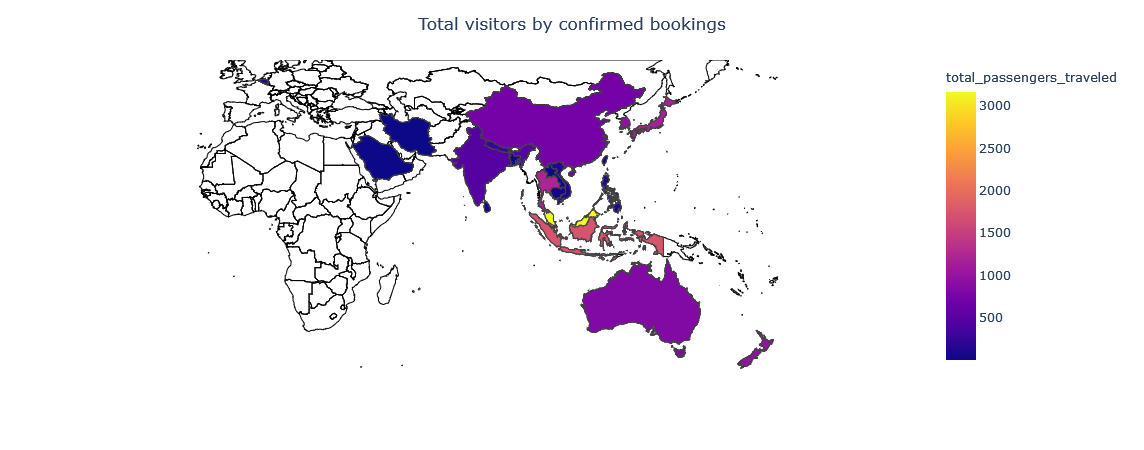

In [112]:
bookings_chloropleth(cty_arr, 'arr_alpha3','total_passengers_traveled', 'cty_arr',
                     color_range = (1, cty_arr['total_passengers_traveled'].max()),
                     plot_title = 'Total visitors by confirmed bookings')

<a id = '3.1.1b'></a>
#### [3.1.1b Advanced Bookings in days](#0)

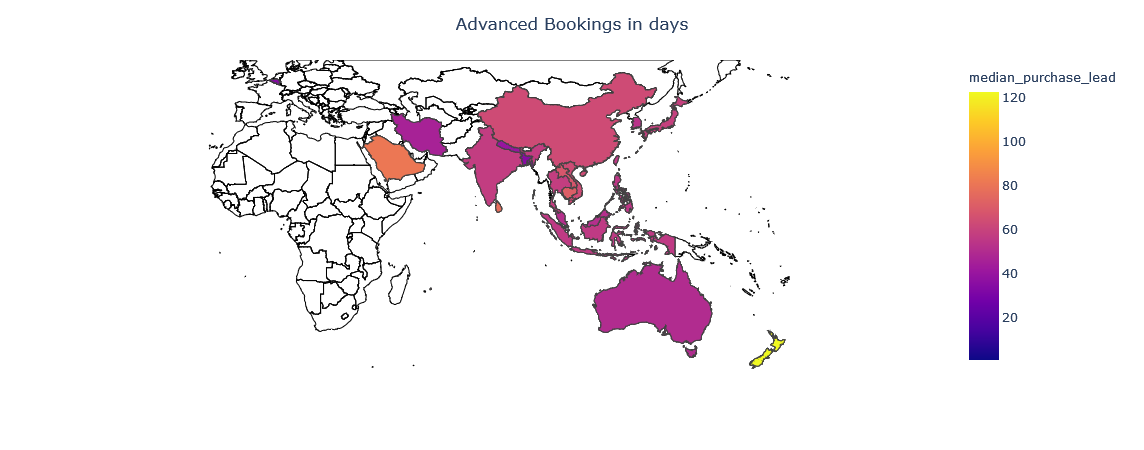

In [113]:
bookings_chloropleth(cty_arr, 'arr_alpha3','median_purchase_lead', 'cty_arr',
                     color_range = (1, cty_arr['median_purchase_lead'].max()),
                     plot_title = 'Advanced Bookings in days')

<a id = '3.1.1c'></a>
#### [3.1.1c Total confirmed bookings by countries of depature](#0)

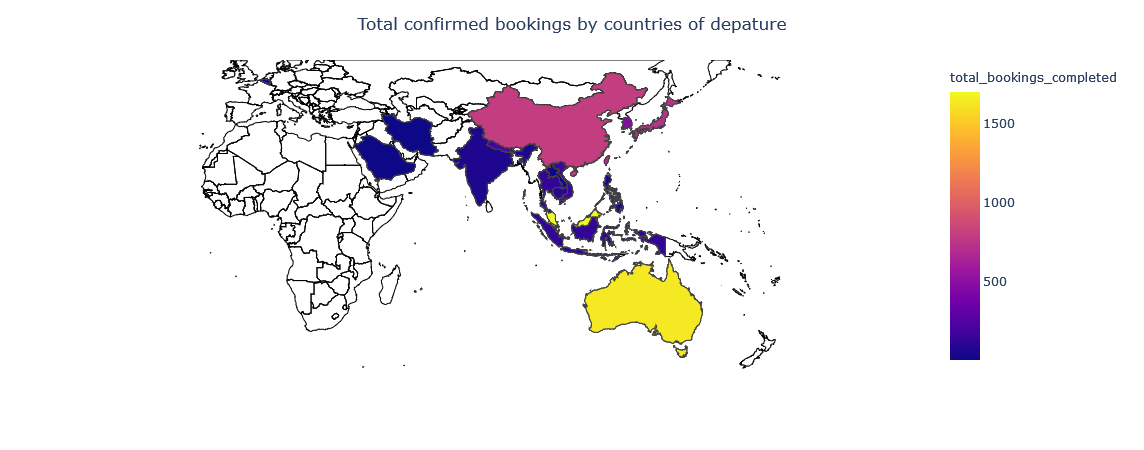

In [114]:
bookings_chloropleth(cty_dep, "dep_alpha3", "total_bookings_completed","cty_dep",
                     color_range =  (1, cty_dep['total_bookings_completed'].max()),
                     plot_title= 'Total confirmed bookings by countries of depature')

<a id = '3.1.1d'></a>
#### [3.1.1d Total confirmed bookings by countries of arrival](#0)

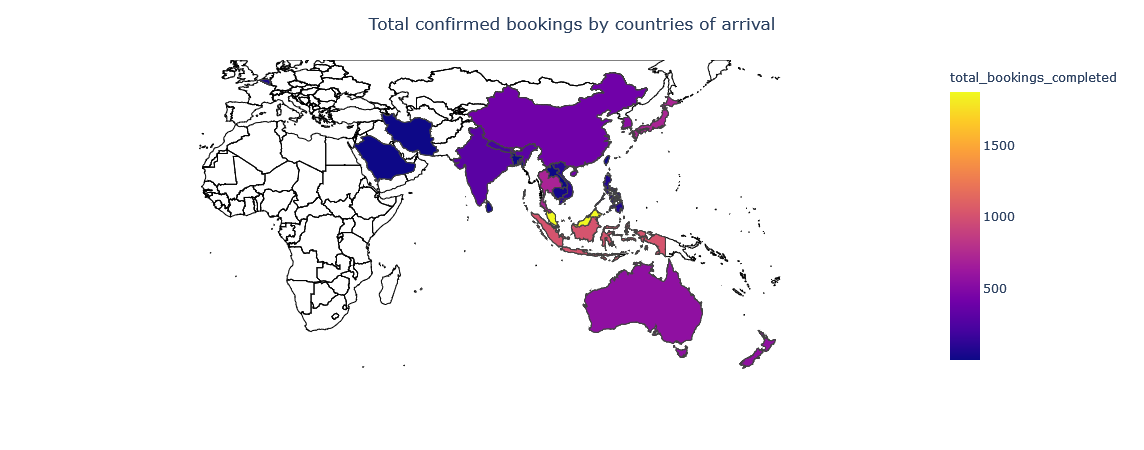

In [115]:
bookings_chloropleth(cty_arr, "arr_alpha3", "total_bookings_completed","cty_arr",
                     color_range =  (1, cty_arr['total_bookings_completed'].max()),
                     plot_title= 'Total confirmed bookings by countries of arrival')

<a id = '3.1.1e'></a>
#### [3.1.1e Total cancelled bookings by countries of departure](#0)

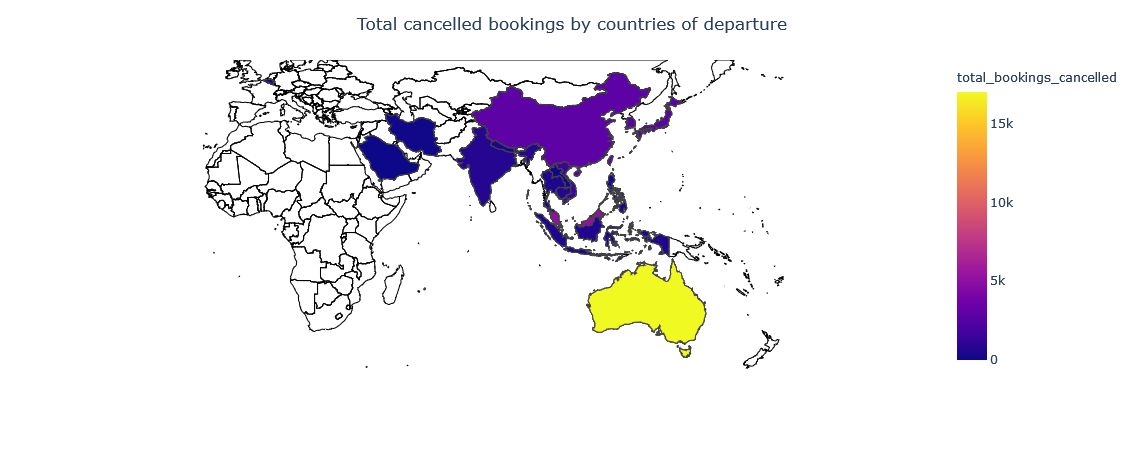

In [116]:
bookings_chloropleth(cty_dep, "dep_alpha3", "total_bookings_cancelled","cty_dep",
                     color_range =  (1, cty_dep['total_bookings_cancelled'].max()),
                     plot_title= 'Total cancelled bookings by countries of departure')

<a id = '3.1.1f'></a>
#### [3.1.1f Total cancelled bookings by countries of arrival](#0)

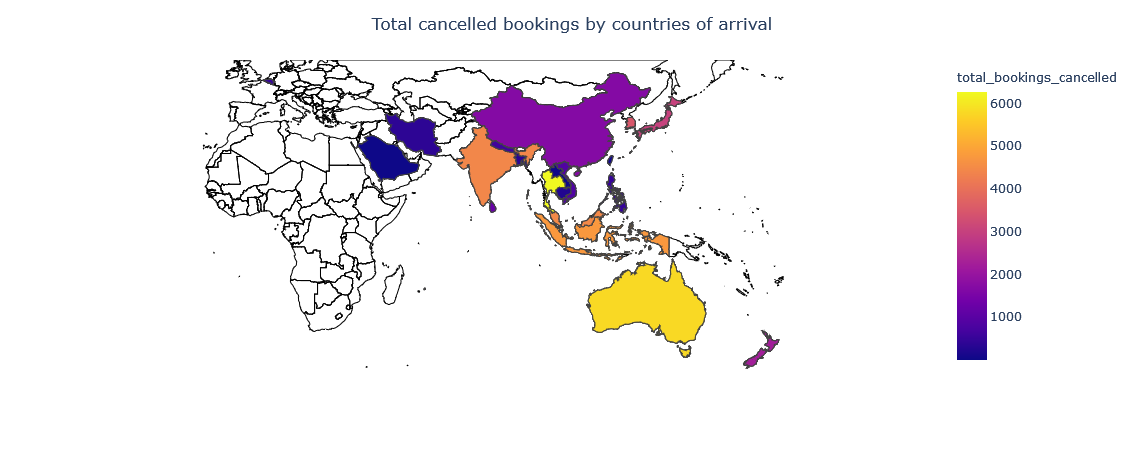

In [117]:
bookings_chloropleth(cty_arr, "arr_alpha3", "total_bookings_cancelled","cty_arr",
                     color_range =  (1, cty_arr['total_bookings_cancelled'].max()),
                     plot_title= 'Total cancelled bookings by countries of arrival')

<a id = '3.1.1g'><a>
#### [3.1.1g Median Length of stay in destination countries](#0)

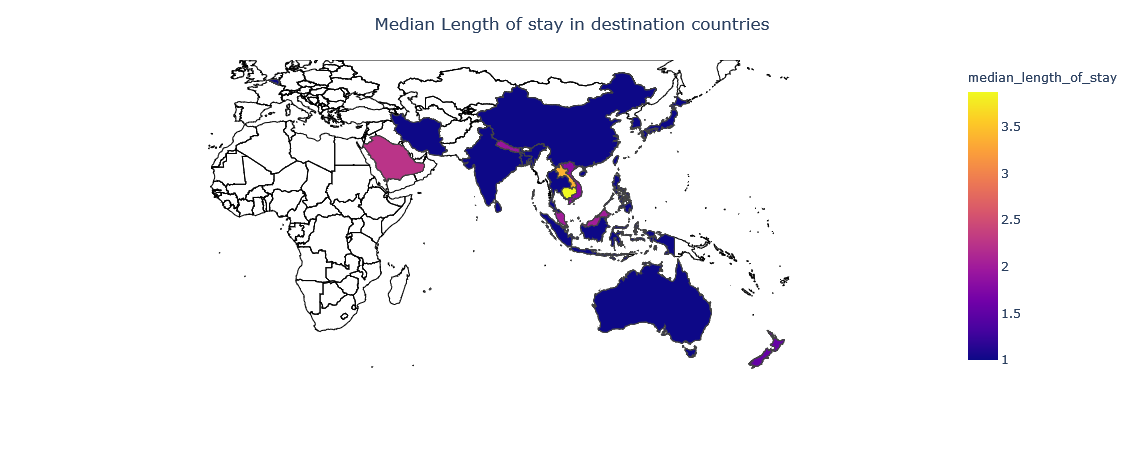

In [118]:
# Median Length of stay in destination countries
bookings_chloropleth(cty_arr, "arr_alpha3", "median_length_of_stay","cty_arr",
                     color_range =  (1, cty_arr['median_length_of_stay'].max()),
                     plot_title= 'Median Length of stay in destination countries')

<a id ='3.1.2'></a>
### [3.1.2 Route level Traffic Analysis with Connection Maps](#0)

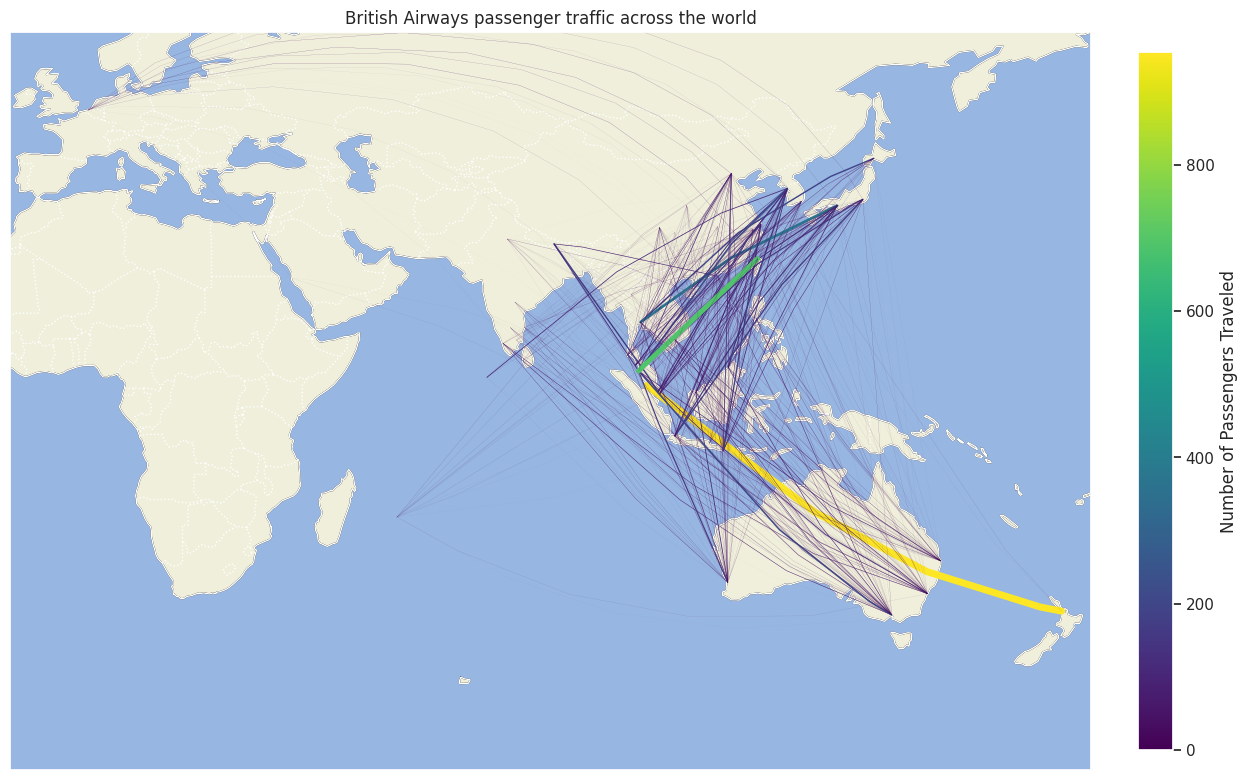

In [119]:
import matplotlib.colors as mcolors

# Create a figure and add a map projection
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# Add geographical features
ax.add_feature(cfeature.LAND, edgecolor='black', zorder=1)
ax.add_feature(cfeature.OCEAN, zorder=0)
ax.add_feature(cfeature.COASTLINE, edgecolor='white', zorder=1)
ax.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='white', zorder=1)

# Set the extent to focus on the desired area
ax.set_extent([-10.5, 180, -65, 65], crs=ccrs.PlateCarree())

# Define pairs of departure and arrival airports
airport_pairs = zip(routes_df['latlong_arr'],routes_df['latlong_dep'])

# Define frequency of travel for each route
frequencies = routes_df['total_passengers_traveled'].tolist()

# Normalize frequencies for colormap
freq_norm = (frequencies-np.min(frequencies))/(np.max(frequencies)-np.min(frequencies))
norm = mcolors.Normalize(vmin=min(frequencies), vmax=max(frequencies))
cmap = plt.cm.viridis

# Add a color bar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', fraction=0.03, pad=0.04)
cbar.set_label('Number of Passengers Traveled')

# Plot great circle routes with linewidth based on frequency for each pair of airports
for i, (dep, arr) in enumerate(airport_pairs):
    startlat, startlon = dep
    arrlat, arrlon = arr
    color = cmap(norm(frequencies[i]))
    ax.plot([startlon, arrlon], [startlat, arrlat],  color=color, linewidth=freq_norm[i]*5,
            transform=ccrs.Geodetic(), zorder=2)

# Add markers for the start and end points
for dep, arr in airport_pairs:
    for airport in [dep, arr]:
        ax.plot(airport[1], airport[0], 'ro', transform=ccrs.PlateCarree(), zorder=3)

title ='British Airways passenger traffic across the world'
plt.title(title)
plt.savefig(f'{title}.jpg')
# Show the plot
plt.show()


**XGBoostClassifier, CatBoostCssifier and other algorithms are capable of handling categorical features** without numeric encodings, **unlike ensemble algorithms like Adaboost or RandomForest**. I will use this to prevent the use of a dataset with increased dimensionality.

In [120]:
del(routes_df)
del(cty_arr)
del(cty_dep)

When dealing with a dataset containing a mix of object (categorical) and numeric features, along with a binary target variable, you can perform various statistical tests and analyses to understand the relationships and make predictions. Here are some common techniques:

1. **Chi-square Test of Independence**:
   - Used to determine whether there is a significant association between two categorical variables.
   - Helps in understanding if there is a relationship between categorical features and the binary target.

2. **T-test**:
   - Used to determine whether there is a significant difference between the means of two groups.
   - Can be applied when you have a numeric feature and a binary target to test if the means of the numeric variable differ significantly between the two groups defined by the binary target.

3. **ANOVA (Analysis of Variance)**:
   - Extends the concept of the t-test to more than two groups.
   - Helps in comparing the means of a numeric variable across multiple groups defined by a categorical variable.
   - If the categorical variable has only two levels, ANOVA reduces to a t-test.

4. **Logistic Regression**:
   - Useful for modeling the relationship between a binary target variable and one or more independent variables (both categorical and numeric).
   - Provides insights into the effect of each feature on the probability of the target being in a particular class.

5. **Feature Importance Analysis**:
   - Techniques like Random Forest, Gradient Boosting Machines, or XGBoost can be used to assess the importance of features in predicting the binary target.
   - These models inherently provide feature importance scores, indicating the contribution of each feature to the prediction.

6. **Correlation Analysis**:
   - Helps in understanding the linear relationship between numeric features and the binary target.
   - While Pearson correlation is commonly used for continuous variables, other correlation measures like Point-Biserial correlation or Rank-Biserial correlation can be used for numeric-binary associations.

7. **Information Gain / Mutual Information**:
   - Measures the reduction in uncertainty about the target variable provided by a feature.
   - Particularly useful for feature selection in machine learning tasks, especially when dealing with categorical variables.

8. **Resampling Techniques**:
   - Techniques like cross-validation, bootstrapping, or permutation tests can provide insights into the stability and reliability of model performance metrics when dealing with imbalanced datasets or small sample sizes.

The choice of statistical tests and analyses depends on the specific characteristics of your dataset, the research question you want to answer, and the assumptions underlying each method. It's often useful to apply multiple techniques to gain a comprehensive understanding of the data and its relationship with the target variable.

<a id = '3.3' ></a>
## [3.3 Correlation Analysis](#0)

https://illumin.usc.edu/the-algorithm-behind-plane-ticket-prices-and-how-to-get-the-best-deal/

https://www.investopedia.com/ask/answers/113015/do-plane-tickets-get-cheaper-closer-date-departure.asp

In [121]:
plt.style.use("ggplot")

plt.rcParams['figure.figsize']=8,5

def corr_map(df = df, title='Correlation Heatmap', savefig_name='corr_map.jpg', method='pearson',
             numeric_only = True, tick_size = 10, annot_size=14,
             annot_kws=8, cbar=False):

    mask = np.triu(np.ones_like(df.corr(numeric_only=numeric_only), dtype=bool))

    heatmap = sns.heatmap(df.corr(method=method, numeric_only = numeric_only),
                          fmt = '.2f', cbar=cbar, annot = True,
                          annot_kws = {'size': annot_kws}, mask=mask, cmap='BrBG')

    plt.xticks(rotation=80, fontsize= tick_size)
    plt.yticks( fontsize= tick_size)

    heatmap.set_title(title+': '+method, fontdict={'fontsize':annot_size}, pad=12)
    plt.tight_layout()
    plt.savefig(title+': '+method)
    plt.show();

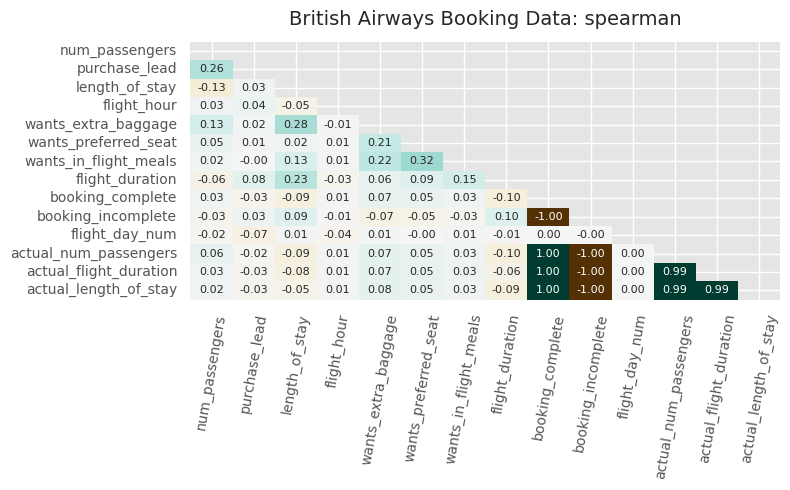

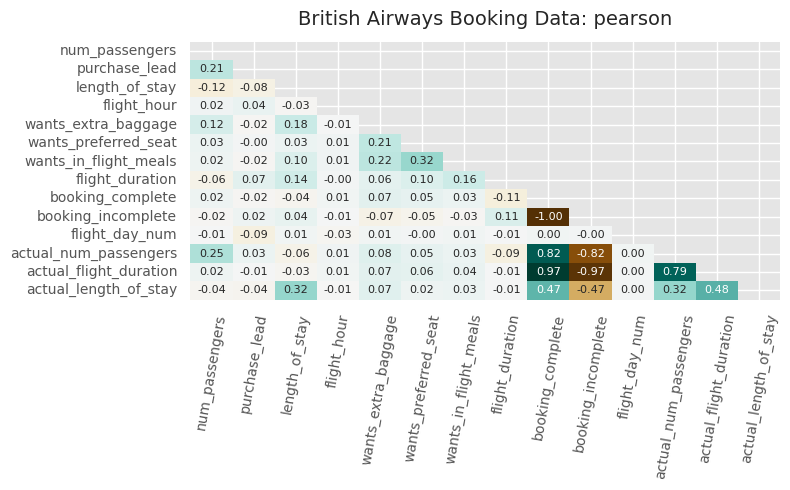

In [122]:
corr_map(title = 'British Airways Booking Data', method='spearman')
corr_map(title = 'British Airways Booking Data', method='pearson')

<a id = '3.4'></a>
## [3.4 Univariate Analysis](#0)

In [123]:
if 'booking_incomplete' in df.columns.tolist():
    df.drop('booking_incomplete', axis =1, inplace=True)
df.select_dtypes(exclude = 'O').columns

Index(['num_passengers', 'purchase_lead', 'length_of_stay', 'flight_hour',
       'wants_extra_baggage', 'wants_preferred_seat', 'wants_in_flight_meals',
       'flight_duration', 'booking_complete', 'flight_day_num',
       'actual_num_passengers', 'actual_flight_duration',
       'actual_length_of_stay'],
      dtype='object')

In [124]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
num_passengers,49281.000,1.590,1.017,1.000,1.000,1.000,2.000,9.000
purchase_lead,49281.000,84.723,90.410,0.000,21.000,51.000,115.000,867.000
length_of_stay,49281.000,23.054,33.832,0.000,5.000,17.000,28.000,778.000
flight_hour,49281.000,9.071,5.413,0.000,5.000,9.000,13.000,23.000
wants_extra_baggage,49281.000,0.668,0.471,0.000,0.000,1.000,1.000,1.000
wants_preferred_seat,49281.000,0.296,0.456,0.000,0.000,0.000,1.000,1.000
wants_in_flight_meals,49281.000,0.427,0.495,0.000,0.000,0.000,1.000,1.000
flight_duration,49281.000,7.280,1.496,4.670,5.620,7.570,8.830,9.500
booking_complete,49281.000,0.150,0.357,0.000,0.000,0.000,0.000,1.000
flight_day_num,49281.000,3.899,1.925,1.000,2.000,4.000,6.000,7.000


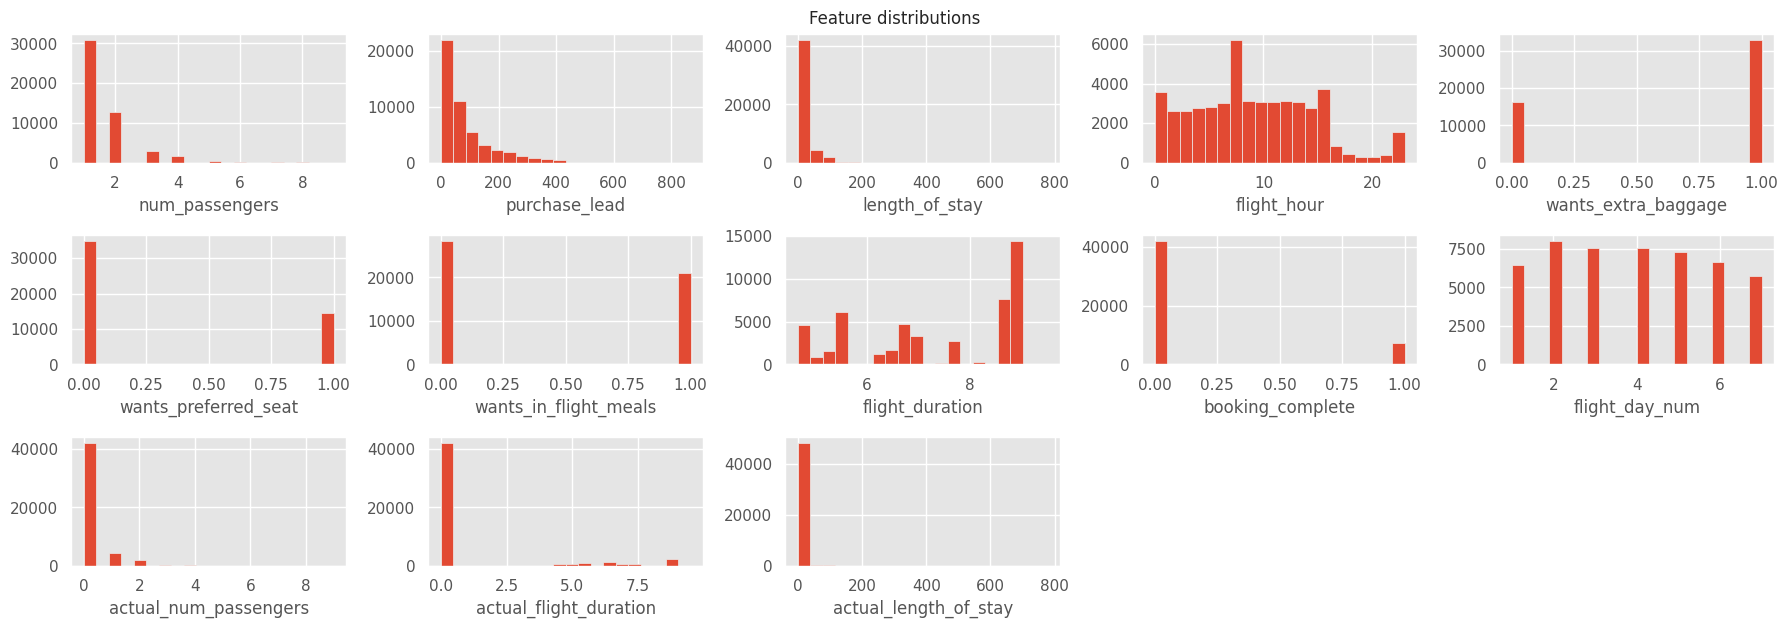

In [125]:
## Lets visualize the feature distributions
fig = plt.figure(figsize = (18,12))
for idx, feature in enumerate(df.select_dtypes(include =[np.number]).columns):
    sub = fig.add_subplot(6,5,idx+1)
    sub.set_xlabel(feature)
    df[feature].hist(bins = 20)


plt.suptitle('Feature distributions')
plt.tight_layout()
plt.savefig('Feature distributions.jpg');

<a id = '3.5'></a>
## [3.5 Bivariate Analysis](#0)

**`purchase_lead` and `length_of_stay` have abnormally large values. Lets use feature transformations.**

In [126]:
## Log Transformation to reduce the outliers
df['log_purchase_lead'] = np.log(df['purchase_lead']+1)
df['log_length_of_stay'] = np.log(df['length_of_stay']+1)

In [127]:
## Group the features
target = 'booking_complete'

cat_feats = ['flight_day','sales_channel', 'trip_type','route', 'booking_origin',
       'port_dep', 'port_arr','cty_dep', 'cty_arr']

for col in df[cat_feats].columns:
    df[col] = df[col].astype('category')

num_feats = df.drop(target, axis=1).select_dtypes(include=[np.number]).columns

coord_feats = [ 'lat_arr', 'lon_arr', 'lat_dep', 'lon_dep',
       'latlong_arr', 'latlong_dep']

drop_list.extend(coord_feats)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49281 entries, 0 to 49280
Data columns (total 30 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   num_passengers          49281 non-null  int64   
 1   sales_channel           49281 non-null  category
 2   trip_type               49281 non-null  category
 3   purchase_lead           49281 non-null  int64   
 4   length_of_stay          49281 non-null  int64   
 5   flight_hour             49281 non-null  int64   
 6   flight_day              49281 non-null  category
 7   route                   49281 non-null  category
 8   booking_origin          49281 non-null  category
 9   wants_extra_baggage     49281 non-null  int64   
 10  wants_preferred_seat    49281 non-null  int64   
 11  wants_in_flight_meals   49281 non-null  int64   
 12  flight_duration         49281 non-null  float64 
 13  booking_complete        49281 non-null  int64   
 14  flight_day_num        

<a id = '3.5.1'></a>
### [3.5.1 Tests for Feature Selection](#0)

<a id = '3.5.1a'></a>
#### [3.5.1a Q-Q Plots for Feature Normality Check](#0)

The dots should approximately lie on a straight-line for a normal distribution. If not, it would be ideal to standardize these features. 

This is a probability plot of sample data against the quantiles of a specified theoretical distribution (in this case, the normal distribution).

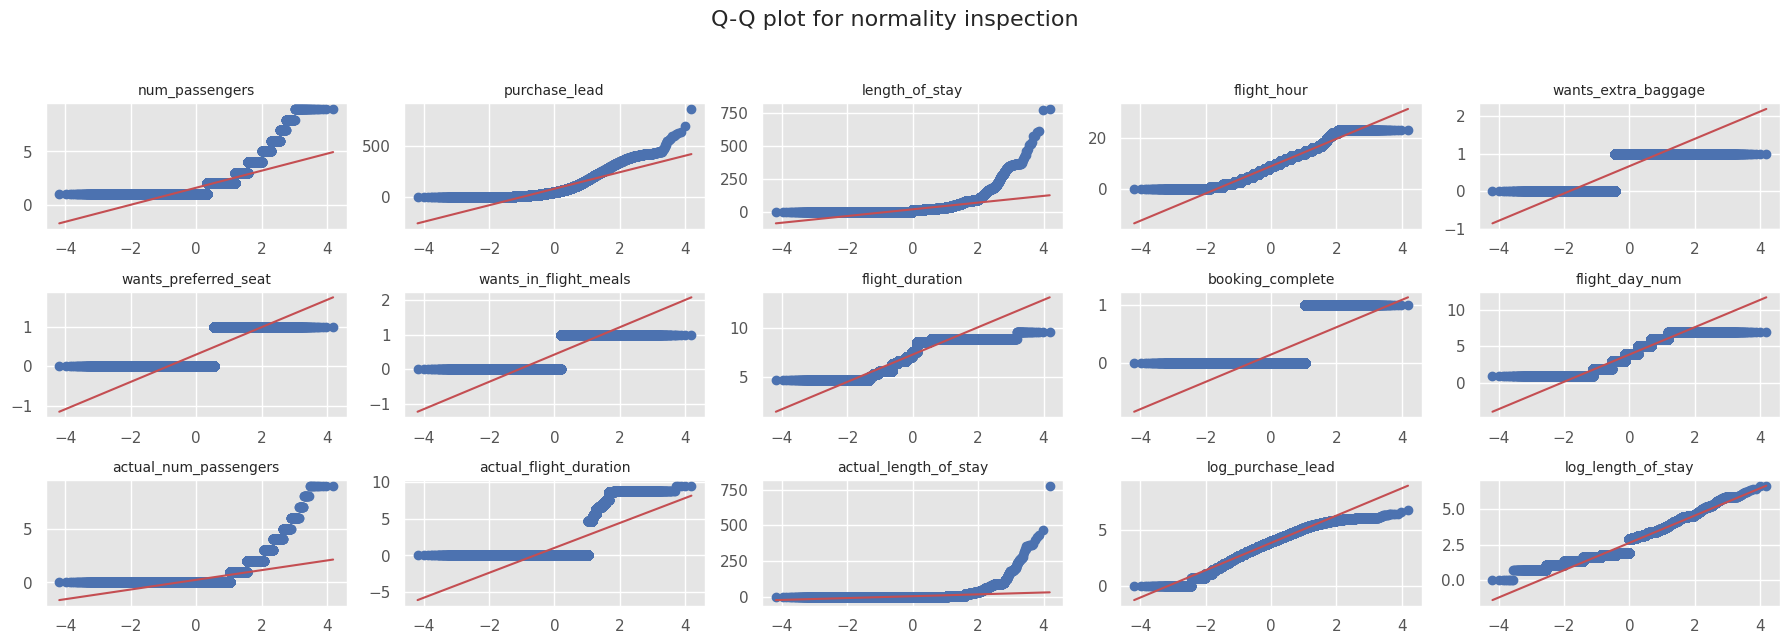

In [128]:
# Q-Q plot
import scipy.stats as stats

fig = plt.figure(figsize = (18,12))
# Iterate over all columns with numerical data
numerical_columns = df.select_dtypes(include=[np.number]).columns

for idx, feature in enumerate(numerical_columns):
    sub = fig.add_subplot(6, 5, idx+1)
    stats.probplot(df[feature], dist="norm", plot=sub)
    sub.set_title(feature, fontsize=10)
    sub.set_xlabel('')
    sub.set_ylabel('')

plt.suptitle('Q-Q plot for normality inspection', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust rect to leave space for suptitle
plt.savefig('Q-Q_plot_for_normality_inspection.jpg')
plt.show()

**None of the features are normally distributed, since the points do not lie along the red line.**

<a id = '3.5.1b'></a>
#### [3.5.1b Kruskal-Wallis H-test, Two-sampled t-test, One-way ANOVA for feature relevance](#0)

**Now let's run some tests to understand feature reevance for model-building**
- The one-way ANOVA tests the null hypothesis that two or more groups have
the same population mean.  The test is applied to samples from two or
more groups, possibly with differing sizes.
- The T-test for the means of *two independent* samples of scores is a test for the null hypothesis that 2 independent samples
have identical average (expected) values. This test assumes that the
populations have identical variances by default.
- The Kruskal-Wallis H-test tests the null hypothesis that the population
median of all of the groups are equal.  It is a non-parametric version of
ANOVA.  The test works on 2 or more independent samples, which may have
different sizes.  Note that rejecting the null hypothesis does not
indicate which of the groups differs.  Post hoc comparisons between
groups are required to determine which groups are different.

If the test statistic is high and the p-value < 0.05, we will reject the null hypothesis for these tests.

*In this case, it would mean that the features are not informative enough to add discriminatory power to the classification model.*

In [129]:
from scipy.stats import f_oneway, ttest_ind, kruskal

x0 = df[df['booking_complete'] == 0]
x1 = df[df['booking_complete'] == 1]

f_statistic, p_value, feature, kru_statistic, kru_pvalue, t_statistic, t_pvalue = [], [], [], [], [], [], []
for feat in df.drop('booking_complete', axis=1).select_dtypes(include = [np.number]).columns:

    fstat, p_val = f_oneway(x0[feat], x1[feat], axis=0)
    kr_stat, kr_pval = kruskal(x0[feat], x1[feat], axis=0, nan_policy='propagate', keepdims=False)
    t_stat, t_pval = ttest_ind(x0[feat], x1[feat],random_state=42, )

    feature.append(feat)

    f_statistic.append(fstat)
    p_value.append(p_val)
    kru_statistic.append(kr_stat)
    kru_pvalue.append(kr_pval)

    t_statistic.append(t_stat)
    t_pvalue.append(t_pval)

    #print(f'{feature}:\t', stat, p_val)

variance_df = pd.DataFrame()
variance_df['feature'] = pd.Series(feature)

variance_df['f_statistic'] = pd.Series(f_statistic)
variance_df['f_pvalue'] = pd.Series(p_value)

variance_df['kru_statistic'] = pd.Series(kru_statistic)
variance_df['kru_pvalue'] = pd.Series(kru_pvalue)

variance_df['t_statistic'] = pd.Series(t_statistic)
variance_df['t_pvalue'] = pd.Series(t_pvalue)

variance_df.set_index('feature', inplace = True)
variance_df

,f_statistic,f_pvalue,kru_statistic,kru_pvalue,t_statistic,t_pvalue
feature,,,,,,
num_passengers,28.620,0.000,37.078,0.000,-5.350,0.000
purchase_lead,24.150,0.000,55.724,0.000,4.914,0.000
length_of_stay,87.414,0.000,369.944,0.000,9.350,0.000
flight_hour,2.216,0.137,7.987,0.005,-1.488,0.137
wants_extra_baggage,231.991,0.000,230.909,0.000,-15.231,0.000
wants_preferred_seat,124.446,0.000,124.135,0.000,-11.156,0.000
wants_in_flight_meals,34.367,0.000,34.344,0.000,-5.862,0.000
flight_duration,565.655,0.000,472.099,0.000,23.784,0.000
flight_day_num,0.825,0.364,0.911,0.340,-0.908,0.364


I can safely drop the two features now for which the p-value>>0.05
and has low f-statistic for all three tests.

I will also drop the cardinal feature flight_day and log-transformed features ['length_of_stay','purchase_lead',]

In [130]:
drop_list.extend(['flight_hour', 'flight_duration'])
drop_list.extend(['length_of_stay','purchase_lead','flight_day'])

<a id = '3.5.2'></a>
#### [3.5.2 Low Cardinality Features vs Target Boxenplots](#0)

In [131]:
bool_feats = [col for col in num_feats if df[col].nunique() ==2]
bool_feats

drop_features= [ *drop_list, *bool_feats, target]

low_card = [col for col in df.drop(drop_features, axis=1).columns if df[col].nunique()<10]
low_card

['num_passengers', 'sales_channel', 'trip_type', 'flight_day_num']

In [132]:
#### Bivariate: feature vs target
def boxenplot(x = target, df = df, drop_features= [ *drop_list,*bool_feats, target]):
    '''
    Boxenplot generator.

    x   = Feature to be represented on x-axis
    df  = Pandas dataframe
    drop_features = Any features to be left out from the dataframe

    Returns:
    A horizonatally arranged subplots of boxenpot
    '''
    drop_features = drop_features+[x]
    numerical_columns = df.drop(drop_features, axis =1).select_dtypes(include=[np.number]).columns

    # Determine the number of subplots
    num_features = len(numerical_columns)
    num_cols = 4  # Set to 4 columns per row
    num_rows = (num_features + num_cols - 1) // num_cols

    fig = plt.figure(figsize = (16,num_rows * 4))
    for idx, feature in enumerate(numerical_columns):
        sub = fig.add_subplot(num_rows, num_cols, idx+1)
        sns.boxenplot(data=df, x=x, y=feature, flier_kws={"marker": "x"}, dodge=True, ax=sub)
        #sns.boxenplot(df, x = x, y = feature,  flier_kws={"marker": "x"}, dodge = True)
        sub.set_xlabel(x)
        sub.set_ylabel(feature)
        sub.tick_params(axis='x', rotation=45)  # Correct way to rotate x-axis labels

    plt.tight_layout()
    plt.suptitle(f'{x} vs features: boxenplots', y=1.02)
    plt.savefig(f'boxen_{x}_vs_features.png', bbox_inches='tight')
    plt.show()



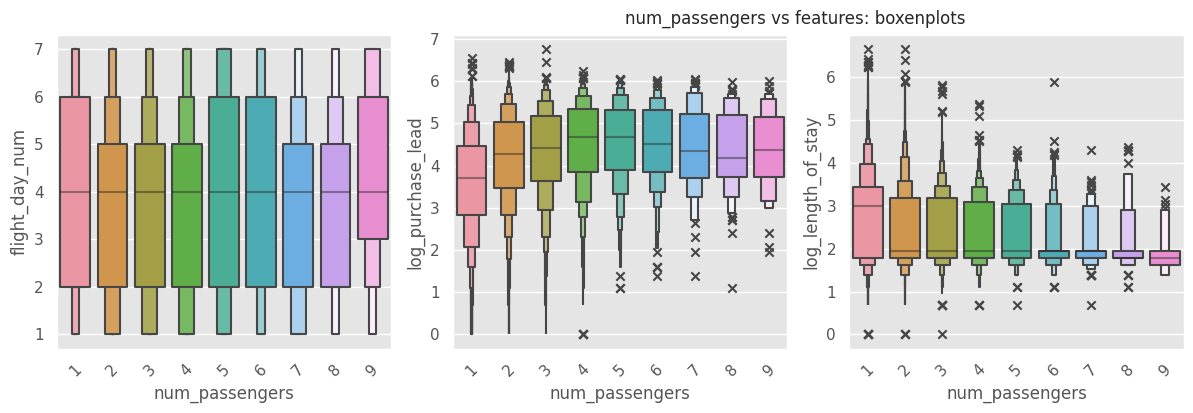

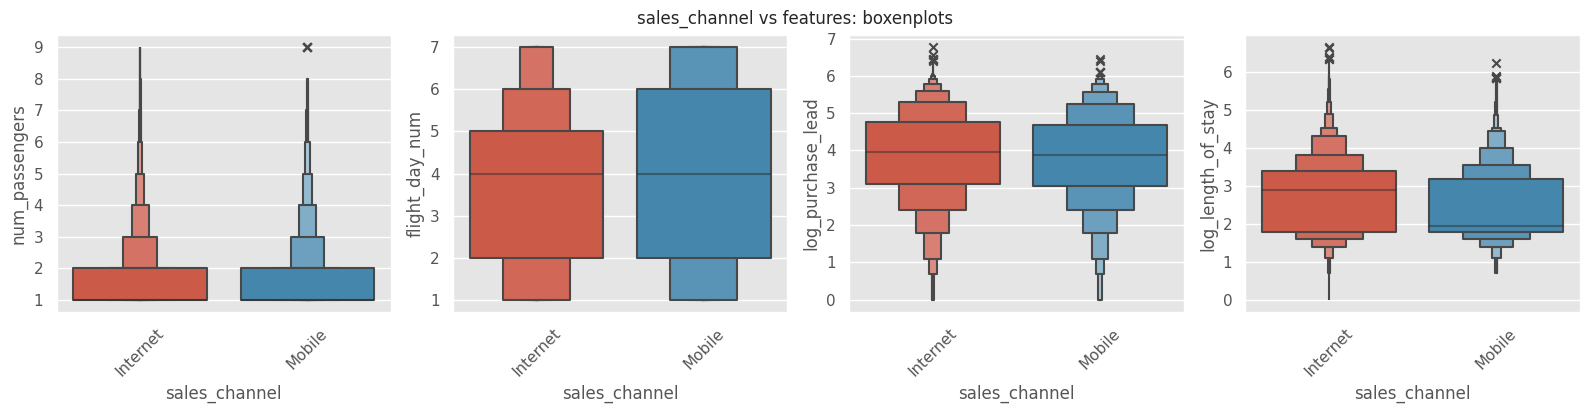

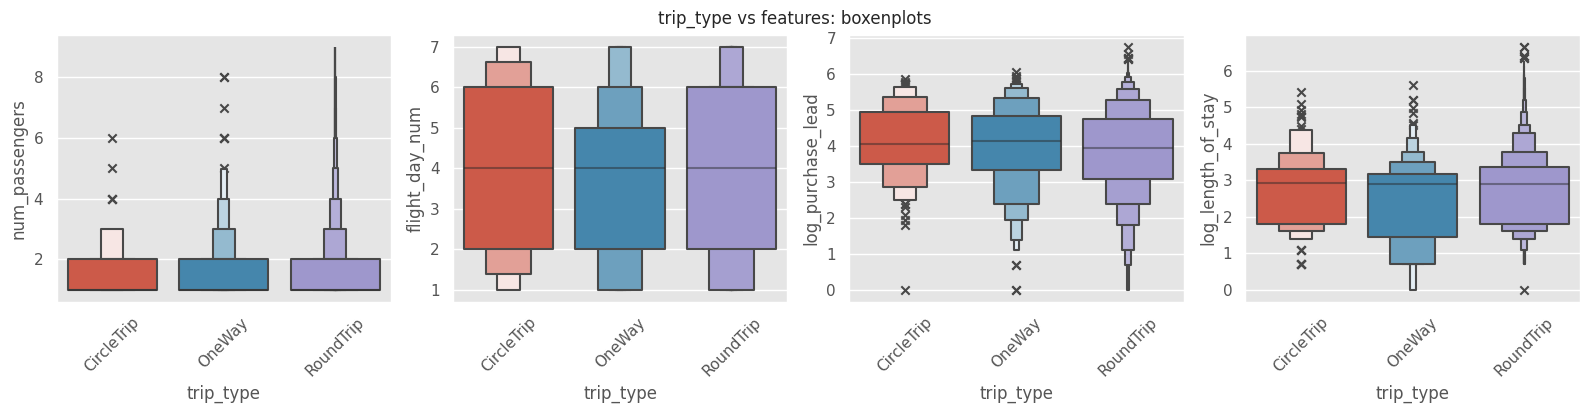

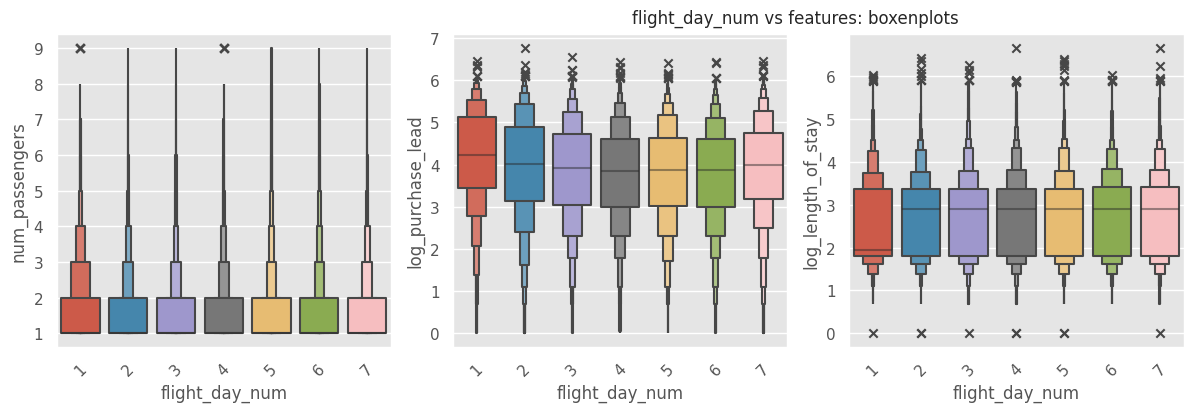

In [133]:
for x in low_card:
    boxenplot(x = x)

<a id = '4'></a>
# [4. Predictive modeling](#0)

<a id = '4.1'></a>
## [4.1 Feature Selection](#0)

Lets select the final features for building the binary classification model for predicting Customer Booking Behaviour

In [134]:
# Convert 64-bit numeric features to 32-bit features to save in-memory use

for col in df.columns:        
    if df[col].dtype == 'int64':
        df[col] = df[col].astype('int32')

    if df[col].dtype == 'float64':
        df[col] = df[col].astype('int32')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49281 entries, 0 to 49280
Data columns (total 30 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   num_passengers          49281 non-null  int32   
 1   sales_channel           49281 non-null  category
 2   trip_type               49281 non-null  category
 3   purchase_lead           49281 non-null  int32   
 4   length_of_stay          49281 non-null  int32   
 5   flight_hour             49281 non-null  int32   
 6   flight_day              49281 non-null  category
 7   route                   49281 non-null  category
 8   booking_origin          49281 non-null  category
 9   wants_extra_baggage     49281 non-null  int32   
 10  wants_preferred_seat    49281 non-null  int32   
 11  wants_in_flight_meals   49281 non-null  int32   
 12  flight_duration         49281 non-null  int32   
 13  booking_complete        49281 non-null  int32   
 14  flight_day_num        

In [135]:
final_features = ['num_passengers', 'sales_channel', 'trip_type', 'route',
       'booking_origin', 'wants_extra_baggage', 'wants_preferred_seat',
       'wants_in_flight_meals', 'flight_day_num', 'port_dep', 'port_arr',
       'cty_dep', 'cty_arr', 'log_purchase_lead', 'log_length_of_stay']
display(final_features)

X = df[final_features]
y = df[target]

['num_passengers',
 'sales_channel',
 'trip_type',
 'route',
 'booking_origin',
 'wants_extra_baggage',
 'wants_preferred_seat',
 'wants_in_flight_meals',
 'flight_day_num',
 'port_dep',
 'port_arr',
 'cty_dep',
 'cty_arr',
 'log_purchase_lead',
 'log_length_of_stay']

<a id = '4.2'></a>
## [4.2 Imports and Setting-up Training Inputs](#0)

In [136]:
%time
!pip install -U hyperopt eli5 shap lime --quiet
!pip install xgboost --quiet
!pip install ipywidgets --quiet
!jupyter nbextension enable --py widgetsnbextension


# Modules for filtering and feature selection
from scipy.stats import kendalltau, zscore

# Modules for model tuning, causal inference, and model explainability
import hyperopt, eli5, shap
from sklearn.inspection import PartialDependenceDisplay
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK, space_eval
from sklearn.model_selection import RandomizedSearchCV, cross_val_score

# Modules for classification
import xgboost as xgb
from xgboost import XGBClassifier, plot_importance, cv, DMatrix
import joblib

# Modules for model evaluation
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV

# print the JS visualization code to the notebook
shap.initjs()

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.58 µs
Config option `kernel_spec_manager_class` not recognized by `EnableNBExtensionApp`.
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [137]:
X_train, X_test, y_train, y_test =  train_test_split(X, y,
                                                     test_size = 0.25,
                                                     shuffle = True,
                                                     stratify = y,
                                                     random_state = 42)

'''
# Setting up a dev set. The dev set has to have the same distribution as the test set
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test,
                                                  test_size = 0.2,
                                                  shuffle = True,
                                                  stratify = y_test_,
                                                  random_state = 42)
'''

X_train, y_train = X_train.reset_index(drop=True), y_train.reset_index(drop=True)
X_test, y_test = X_test.reset_index(drop=True), y_test.reset_index(drop=True)
#X_val, y_val = X_val.reset_index(drop=True), y_val.reset_index(drop=True)

In [138]:
# Compute sample weights for a binary classification problem with labels y_train

from sklearn.utils.class_weight import compute_sample_weight
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

# Print the computed sample weights
print("Sample Weights:", sample_weights)

sample_weights_test = compute_sample_weight(class_weight='balanced', y=y_test)
# Print the computed sample weights
print("Test Sample Weights:", sample_weights_test)

Sample Weights: [0.588217 0.588217 3.333935 ... 0.588217 0.588217 0.588217]
Test Sample Weights: [3.333604 3.333604 0.588227 ... 0.588227 3.333604 0.588227]


<a id = '4.3'></a>
## [4.3 Helper functions to track training performance](#0)

In [139]:
from sklearn.metrics import confusion_matrix
def custom_profit_loss(y_pred:np.ndarray or pd.Series, y_true:np.ndarray or pd.Series, 
                       sample_weight:np.ndarray=None, normalize:bool = True):
    """
    Custom loss function that maximizes net profit per customer based on the decision matrix.

    Args:
    y_true : array-like of shape (n_samples,)
        Ground truth (correct) target values.
    y_pred : array-like of shape (n_samples,)
        Estimated probabilities or classes returned by the classifier.
    sample_weight : np.ndarray = Default None
    Returns:
    loss : float
        The custom loss value based on the decision matrix.
    """
    # Define the decision matrix
    # Per customer
    net_revenue = 38.22/5
    net_CAC = 0.76
    net_profit = net_revenue - net_CAC

    X00 = 0 # true negative, no profit
    X01 = -0.1*net_revenue # false positive: 10% of revenues go to marketing and sales costs, post-acquisition
    X10 = -0.76 # false negative: CAC spent
    X11 = net_profit + X01 # true positive: profit per customer minus costs of retention
    
    
    decision_matrix = np.array([[X00, X01],
                                 [X10, X11]])
    
    
    confusion_mx = confusion_matrix(y_test, y_pred, sample_weight = sample_weight)
    cm_norm = confusion_mx.astype('float') / confusion_mx.sum(axis=1)[:, np.newaxis] # Normalized
    
    # Net profit per customer
    if normalize:
        profit = np.sum(np.multiply(cm_norm, decision_matrix)) 
    else:
        profit = np.sum(np.multiply(confusion_mx, decision_matrix))
    return profit  # Negative profit because we want to maximize profit

None
def cl_report(model, X_test = X_test, y_test = y_test, multi_class = False, sample_weights_test = sample_weights_test, optimal_threshold:float = None):
    '''
    Returns:
    auc_score, acc_score, report, confusion_mx, cm_norm, y_pred_classes,y_pred_proba, (fpr, tpr, thresholds)

    Model performance metrics

    auc_score: roc_auc_score
    acc_score: accuracy_score
    report: classification_report
    confusion_mx: confusion_matrix
    cm_norm: confusion_mx, normalized
    y_pred_classes: y_pred_classes
    y_pred_proba: Prediction probabilities
    (fpr, tpr, thresholds): sklearn.metrics.roc_curve

    '''

    y_pred_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba, pos_label =1, sample_weight = sample_weights_test)
    auc_score = roc_auc_score(y_test, y_pred_proba)

    if optimal_threshold:
        y_preds = [1 if prob >= optimal_threshold else 0 for prob in y_pred_proba]
    else:
        y_preds = model.predict(X_test)

    #   accuracy_score, roc_auc_score
    if multi_class:
        y_pred_classes = np.argmax(y_preds, axis=1)
        #y_test_classes = np.argmax(y_test, axis =1)
    else:
        y_pred_classes = y_preds

    auroc = auc_score
    acc_score = accuracy_score(y_test, y_pred_classes)
    report = classification_report(y_test, y_pred_classes)
    confusion_mx = confusion_matrix(y_test, y_pred_classes, sample_weight = sample_weights_test)
    cm_norm = confusion_mx.astype('float') / confusion_mx.sum(axis=1)[:, np.newaxis]

    return auc_score, acc_score, report, confusion_mx, cm_norm, y_pred_classes, y_pred_proba, (fpr, tpr, thresholds)

<a id = '4.4'></a>
## [4.4 Model Tuning using Hyperparameter Tuning with Bayesian Optimization search](#0)

In [140]:
'''
XGBoost Bayesian Optimization
'''
from xgboost import cv, DMatrix
# Prepare the data
d_train = DMatrix(X_train, label=y_train, weight=sample_weights, enable_categorical=True)

# Define the objective function for Bayesian optimization
def xgb_cv(params, d_train):
    '''
    Objective function for Hyperopt Bayesian Optimization
    '''
    try:
        # Prepare the data
        d_train = d_train

        # Ensure parameters that need to be integers are integers
        params['max_depth'] = int(params['max_depth'])
        params['n_estimators'] = int(params['n_estimators'])

        # Set additional fixed parameters
        params['objective'] = 'binary:logistic'
        params['eval_metric'] = 'auc'

        # Perform cross-validation
        skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
        cv_results = cv(
            params, d_train, num_boost_round=200, folds=skf,
            seed=42, stratified=True, early_stopping_rounds=60, as_pandas=True
        )

        # Extract and return the mean AUC from cross-validation results
        score = cv_results['test-auc-mean'].mean()#[-1]

        return {'loss': -score, 'params': params, 'status': STATUS_OK}

    except Exception  as e:
        # Log the exception
        print(f"XGBoostError: {e}")
        return {'loss': float('inf'), 'params': params, 'status': STATUS_OK}

In [157]:
%%time
# Perform Bayesian optimization using hyperopt
trials = Trials()
np.set_printoptions(precision=6)
np.seterr(all='ignore')

# Define the search space for hyperparameters
space = {
    'max_depth': hp.quniform('max_depth', 5, 600, 1),
    'n_estimators': hp.quniform('n_estimators', 30, 1800, 10),
    'learning_rate': hp.uniform('learning_rate', 1e-8, 0.5),
    'gamma': hp.uniform('gamma', 0.1, 1000),
    'min_child_weight': hp.uniform('min_child_weight', 0, 1000),
    'subsample': hp.uniform('subsample', 0.1, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.1, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0.1, 1000),
    'reg_alpha': hp.uniform('reg_alpha', 0.1, 1000),
}

#best_xgboost = fmin(fn=lambda params: xgb_cv(params, d_train), space=space, algo=tpe.suggest, max_evals=250, trials=trials)

CPU times: user 1.94 ms, sys: 0 ns, total: 1.94 ms
Wall time: 1.69 ms


In [158]:
def xgb_scores(best_xgboost, space=space):
    '''
    Returns and prints the best hyperparameters and corresponding loss
    '''
    display("Best Hyperparameters:", best_xgboost)
    best_params = space_eval(space, best_xgboost)
    best_loss = -trials.best_trial['result']['loss'] # Revert negation
    display("Best Score (Mean AUC-ROC score):", best_loss)

    return best_loss, best_params

In [143]:
#xgb_scores(best_xgboost)[1]

'Best Hyperparameters:'

{'colsample_bytree': 0.4188879271736084,
 'gamma': 2.1362622139803715,
 'learning_rate': 0.21427097493458175,
 'max_depth': 506.0,
 'min_child_weight': 289.41396743058283,
 'n_estimators': 570.0,
 'reg_alpha': 4.769217567937581,
 'reg_lambda': 33.288137029735324,
 'subsample': 0.7791888848575066}

'Best Score (Mean AUC-ROC score):'

0.7526032092436646

{'colsample_bytree': 0.4188879271736084,
 'gamma': 2.1362622139803715,
 'learning_rate': 0.21427097493458175,
 'max_depth': 506.0,
 'min_child_weight': 289.41396743058283,
 'n_estimators': 570.0,
 'reg_alpha': 4.769217567937581,
 'reg_lambda': 33.288137029735324,
 'subsample': 0.7791888848575066}

#### **Best Hyperparameters**

In [144]:
# @title
'''
Recording Parameters for various runs here
'''

xgb_params15 = {'colsample_bytree': 0.4188879271736084,
 'gamma': 2.1362622139803715,
 'learning_rate': 0.21427097493458175,
 'max_depth': 506,
 'min_child_weight': 289.41396743058283,
 'n_estimators': 570,
 'reg_alpha': 4.769217567937581,
 'reg_lambda': 33.288137029735324,
 'subsample': 0.7791888848575066}
xgb_params14 = {'colsample_bytree': 0.6844627967423743,
 'gamma': 2.3339959251103397,
 'learning_rate': 0.4978974210902924,
 'max_depth': 510,
 'min_child_weight': 19.893312416407014,
 'n_estimators': 670,
 'reg_alpha': 54.86312288712904,
 'reg_lambda': 55.842598820641854,
 'subsample': 0.44040441921566015} # No log-scaled features + booleans set to categorical

xgb_params13 = {'colsample_bytree': 0.8996499816061119,
 'gamma': 0.9906146030717551,
 'learning_rate': 0.4648586095327308,
 'max_depth': 318,
 'min_child_weight': 404.9495042854509,
 'n_estimators': 490,
 'reg_alpha': 25.69709097943915,
 'reg_lambda': 203.42815545942142,
 'subsample': 0.9235764139587855} # 1 log-scaled features + booleans set to categorical

xgb_params12 = {'colsample_bytree': 0.6512327618281024,
 'gamma': 0.7485068168155316,
 'learning_rate': 0.33990184627305003,
 'max_depth': 218,
 'min_child_weight': 309.81026235794343,
 'n_estimators': 1800,
 'reg_alpha': 56.993453124710555,
 'reg_lambda': 952.3262934837537,
 'subsample': 0.6765422342087676} # booleans set to categorical

xgb_params11 = {'colsample_bytree': 0.9263912656504909,
 'gamma': 28.58107427305805,
 'learning_rate': 0.15873871864472128,
 'max_depth': 318,
 'min_child_weight': 53.929850544058695,
 'n_estimators': 1180,
 'reg_alpha': 0.5903224040836577,
 'reg_lambda': 485.4345854335321,
 'subsample': 0.5644302762419419}  #0.7761465053099477

# Binary:logistic, test_size = 0.10
xgb_params0 = {'colsample_bytree': 0.6245996540946361,
 'gamma': 2.6023175188180687,
 'learning_rate': 0.3151496714023842,
 'max_depth': 148,
 'min_child_weight': 20.35441348285162,
 'n_estimators': 880,
 'reg_alpha': 30.04847178387434,
 'reg_lambda': 431.6232412904434,
 'subsample': 0.4654989295865096}

xgb_params1 = {'colsample_bytree': 0.7953286776842241,
 'gamma': 16.118725085951013,
 'learning_rate': 0.12475520399747479,
 'max_depth': 187,
 'min_child_weight': 6.3531247706277725,
 'n_estimators': 650,
 'reg_alpha': 9.08649857670294,
 'reg_lambda': 948.0180404974387,
 'subsample': 0.869337285556218}

xgb_params2 = {'colsample_bytree': 0.8376788952443562,
 'gamma': 23.573659109273876,
 'learning_rate': 0.19733467076314132,
 'max_depth': 61,
 'min_child_weight': 6.6447205704599295,
 'n_estimators': 440,
 'reg_alpha': 25.27369729990135,
 'reg_lambda': 683.2919662435726,
 'subsample': 0.9957741870106955} #0.7705907974550088

xgb_params3 = {'colsample_bytree': 0.6753913635439988,
 'gamma': 21.809645882094074,
 'learning_rate': 0.36835387772275413,
 'max_depth': 99,
 'min_child_weight': 0.4731627631508375,
 'n_estimators': 650,
 'reg_alpha': 0.5090403972791,
 'reg_lambda': 179.7912220375381,
 'subsample': 0.9918069327639419} #0.7865304226357439

xgb_params4 = {'colsample_bytree': 0.7206787490185305,
 'gamma': 113.22540402826402,
 'learning_rate': 0.41286555320610385,
 'max_depth': 78.0,
 'min_child_weight': 33.260226895468534,
 'n_estimators': 1240.0,
 'reg_alpha': 20.165611502604,
 'reg_lambda': 736.9466429133059,
 'subsample': 0.8075414679427403} #0.757996948824136

#N_splits (skf) = 10, test_size = 0.10, early_stopping_rounds = 50
xgb_params5 =  {'colsample_bytree': 0.5681784883696,
  'gamma': 0.14380661841316567,
  'learning_rate': 0.13974977226139496,
  'max_depth': 543,
  'min_child_weight': 0.5085950669543602,
  'n_estimators': 500,
  'reg_alpha': 0.9291698968442574,
  'reg_lambda': 102.93373043196078,
  'subsample': 0.626129109629905} # (0.7894819179747935,)

xgb_params8 = {'colsample_bytree': 0.9153543261661337,
 'gamma': 26.056927082212162,
 'learning_rate': 0.04197706013417718,
 'max_depth': 576,
 'min_child_weight': 0.0515531928620554,
 'n_estimators': 1610,
 'reg_alpha': 3.8409658238606283,
 'reg_lambda': 321.94694231544554,
 'subsample': 0.81747265253506} #0.780851725992209

#N_splits (skf) = 15, test_size = 0.15, early_stopping_rounds = 5
xgb_params6  = {'colsample_bytree': 0.34894816393783445,
 'gamma': 170.97221870489506,
 'learning_rate': 0.0764696156222408,
 'max_depth': 565,
 'min_child_weight': 27.057900279875355,
 'n_estimators': 530,
 'reg_alpha': 4.8829591998368596,
 'reg_lambda': 745.2490190854971,
 'subsample': 0.8254911736039082} #0.7516404336147656

xgb_params7 = {'colsample_bytree': 0.8787178013571446,
 'gamma': 473.35782291465415,
 'learning_rate': 0.47552822518458077,
 'max_depth': 422,
 'min_child_weight': 34.56662269722818,
 'n_estimators': 960,
 'reg_alpha': 0.9495753333541757,
 'reg_lambda': 727.3022425119462,
 'subsample': 0.6359359017628432} # 0.7039776297125843

xgb_params10 = {'colsample_bytree': 0.8150954380862233,
 'gamma': 24.36273805559827,
 'learning_rate': 0.19813025003798504,
 'max_depth': 543,
 'min_child_weight': 0.4640892705019004,
 'n_estimators': 350,
 'reg_alpha': 30.811014693181992,
 'reg_lambda': 0.45982307839449366,
 'subsample': 0.8803441893265042} #0.787351476507172

<a id = '4.5'></a>
## [4.5 Model retraining with Best Hyperparameters](#0)

In [159]:
%%time
xgb_refit = XGBClassifier(**xgb_params11,
                          objective='binary:logistic',
                          enable_categorical = True,
                          seed = 42,
                          eval_metric = 'auc',
                          #early_stopping_rounds = 60
                         )

xgb_refit.fit(X_train, y_train, sample_weight = sample_weights)

CPU times: user 7.16 s, sys: 27.7 ms, total: 7.19 s
Wall time: 1.83 s


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9263912656504909, device=None,
              early_stopping_rounds=None, enable_categorical=True,
              eval_metric='auc', feature_types=None, gamma=28.58107427305805,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.15873871864472128,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=318, max_leaves=None,
              min_child_weight=53.929850544058695, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=1180,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

<a id = '4.6'></a>
## [4.6 Threshold Tuning](#0)

Threshold tuning is helpful in improving the model performance, especially if the data is imbalanced. This is achieved by choosing an appropriate point of balance between Sensitivity and Specificity.

In [160]:
auroc_score, _, _, _, _, _,_, auroc_curve = cl_report(model= xgb_refit)

In [161]:
# Faster method: Youden's J-statistic
# https://en.wikipedia.org/wiki/Youden%27s_J_statistic
fpr, tpr, thresholds = auroc_curve
# Sensitivity minus Specificity
J = tpr -fpr
ix = np.argmax(J)
print("Optimal Threshold with Youden's J-statistic:\t",thresholds[ix])

Optimal Threshold with Youden's J-statistic:	 0.48116454


AUC-ROC score:	0.774
Optimum Threshold using Geometric Mean of Sensitivity and Specificity:
Threshold= 0.493637 for G-Mean = 0.712


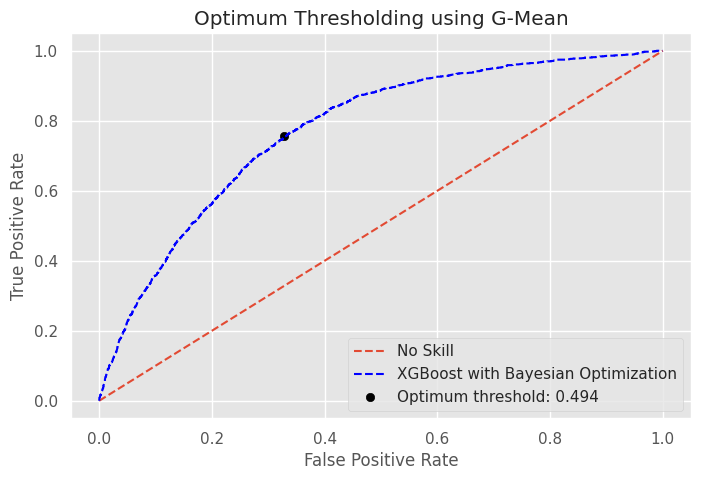

In [162]:
# calculate the g-mean for each threshold (the geometric mean of sensitivity and specificity)
gmeans = np.sqrt(tpr * (1-fpr))

# locate the index of the largest g-mean
ix = np.argmax(gmeans)

thresh_gmean = thresholds[ix]
print(f'AUC-ROC score:\t{auroc_score:.3f}')
print('Optimum Threshold using Geometric Mean of Sensitivity and Specificity:\nThreshold= %f for G-Mean = %.3f' % (thresh_gmean, gmeans[ix]))

# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, linestyle='--', color='blue', label='XGBoost with Bayesian Optimization')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label=f'Optimum threshold: {thresholds[ix]:.3f}')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('Optimum Thresholding using G-Mean')
plt.savefig('Optimum Threshold using Geometric Mean of Sensitivity and Specificity.png')
# show the plot
plt.show()

<a id = '4.7'></a>
## [4.7 Performance Metrics](#0)

In [163]:
auc_score, acc_score, report, confusion_mx, cm_norm, y_pred_classes,y_pred_proba, auroc_curve = cl_report(model= xgb_refit, optimal_threshold = thresh_gmean)

Accuracy Score: 0.684
			Classification report
               precision    recall  f1-score   support

           0       0.94      0.67      0.78     10473
           1       0.29      0.76      0.42      1848

    accuracy                           0.68     12321
   macro avg       0.61      0.71      0.60     12321
weighted avg       0.84      0.68      0.73     12321



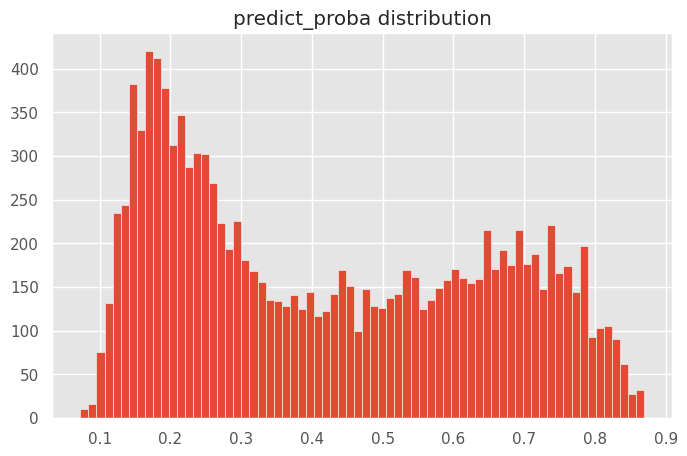

In [164]:
print(f'Accuracy Score: {acc_score:.3f}') #0.6841165489814138

print('\t\t\tClassification report\n', report)

# predict_proba distribution
pd.Series(y_pred_proba).hist(bins=70)
plt.title('predict_proba distribution')
plt.show();

AUROC score:	0.774
Accuracy Score:	0.684

Normalized Confusion Matrix


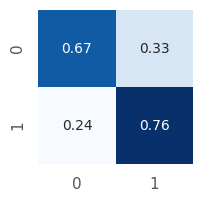

In [165]:
print(f'AUROC score:\t{auc_score:.3f}', )
print(f'Accuracy Score:\t{acc_score:.3f}', )

plt.figure(figsize = (2,2))
sns.heatmap(cm_norm, annot=True, cmap='Blues', cbar =False)
print('\nNormalized Confusion Matrix');

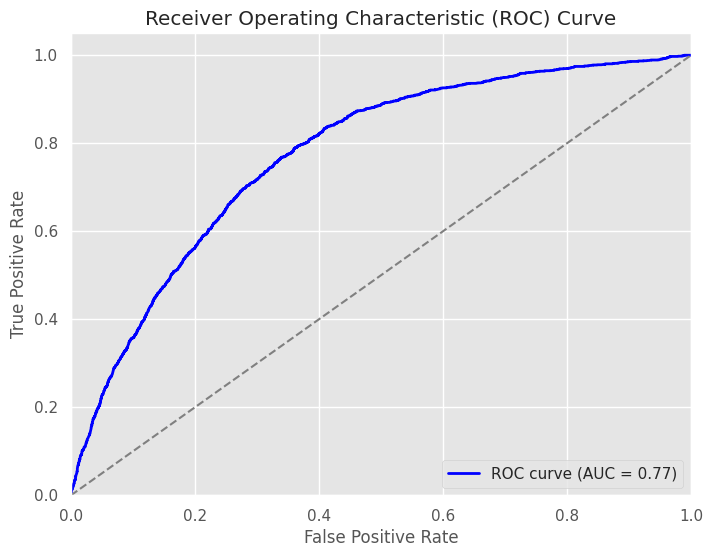

In [152]:
def roc_plot(auroc_curve = auroc_curve, auc_score=auc_score):
    fpr, tpr, thresholds = auroc_curve[0], auroc_curve[1], auroc_curve[2]

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % auc_score)
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()
    
    
roc_plot()

In [166]:
## Save model
xgb_refit.save_model('xgb_model_11.json')

<a id = '5'></a> 
# [5. Model Explanations and Interpretations](#0)

<a id = '5.1'></a>
## [5.1 Feature Importance Plot](#0)

This plot is based on model weights and provides a direct estimate of Feature Influence on predictions.

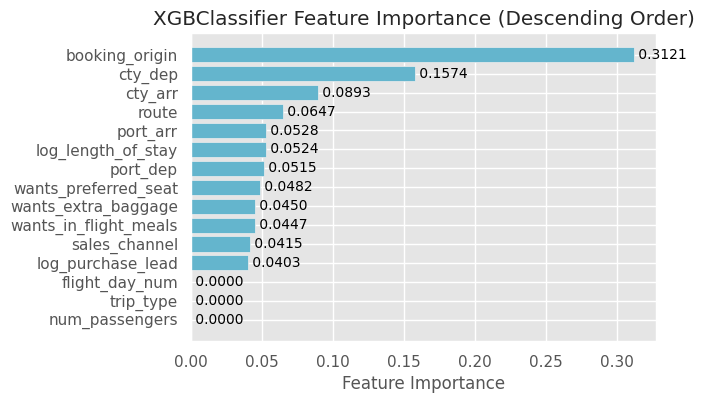

In [167]:
importance = xgb_refit.feature_importances_
features = X_train.columns

# Sort features and importance values in descending order
sorted_idx = importance.argsort()[::-1]
sorted_features = [features[i] for i in sorted_idx]
sorted_importance = [importance[i] for i in sorted_idx]

# Create a horizontal bar chart for feature importance
plt.figure(figsize=(6, 4))
plt.barh(sorted_features, sorted_importance, color='c')
plt.xlabel('Feature Importance')
plt.title('XGBClassifier Feature Importance (Descending Order)')
plt.gca().invert_yaxis()

for i, v in enumerate(sorted_importance):
    plt.text(v, i, f' {v:.4f}', va='center', fontsize=10, color='black')
plt.savefig('XGBClassifier Feature Importance.png')
plt.show();

<a id = '5.2'></a>
## [5.2 Permutation Importance Plot](#0)
The permutation importance plot, also known as permutation feature importance, is a technique used to evaluate the importance of each feature in a machine learning model. It does this by randomly shuffling the values of each feature and measuring the decrease in the model's performance. This decrease in performance is then used to calculate the importance of each feature.

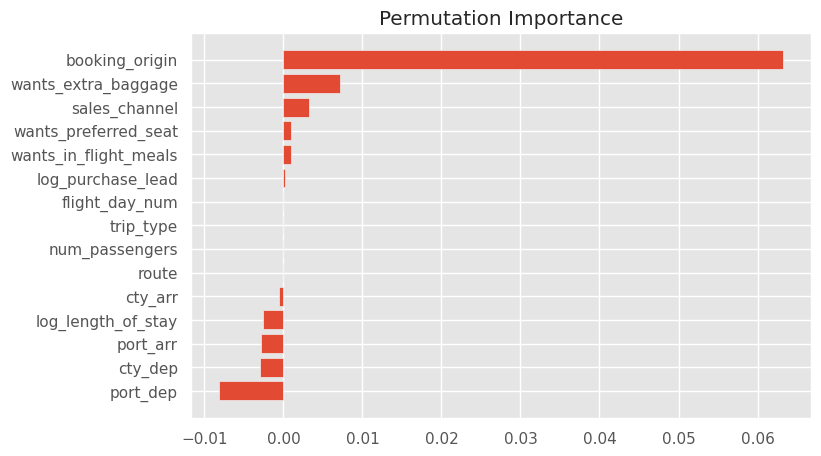

In [168]:
# Permutation feature importance
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(xgb_refit, X_test, y_test)
sorted_idx = perm_importance.importances_mean.argsort()
perm_importance
plt.barh(X_train.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.title("Permutation Importance")
plt.savefig('Permutation Importance.jpg')
plt.show();

Occasionally, negative values for permutation importances can be observed. In those cases, the predictions on the shuffled (or noisy) data happened to be more accurate than the real data. This happens when the feature didn't matter (should have had an importance close to 0), but random chance caused the predictions on shuffled data to be more accurate. This is more common with small datasets, like the one in this example, because there is more room for luck/chance.

<a id = '5.3'></a>
## [5.3 Partial Dependence Plot](#0)
Like permutation importance, partial dependence plots are calculated after a model has been fit. The model is fit on real data that has not been artificially manipulated in any way.

The y axis is interpreted as change in the prediction from what it would be predicted at the baseline or leftmost value.

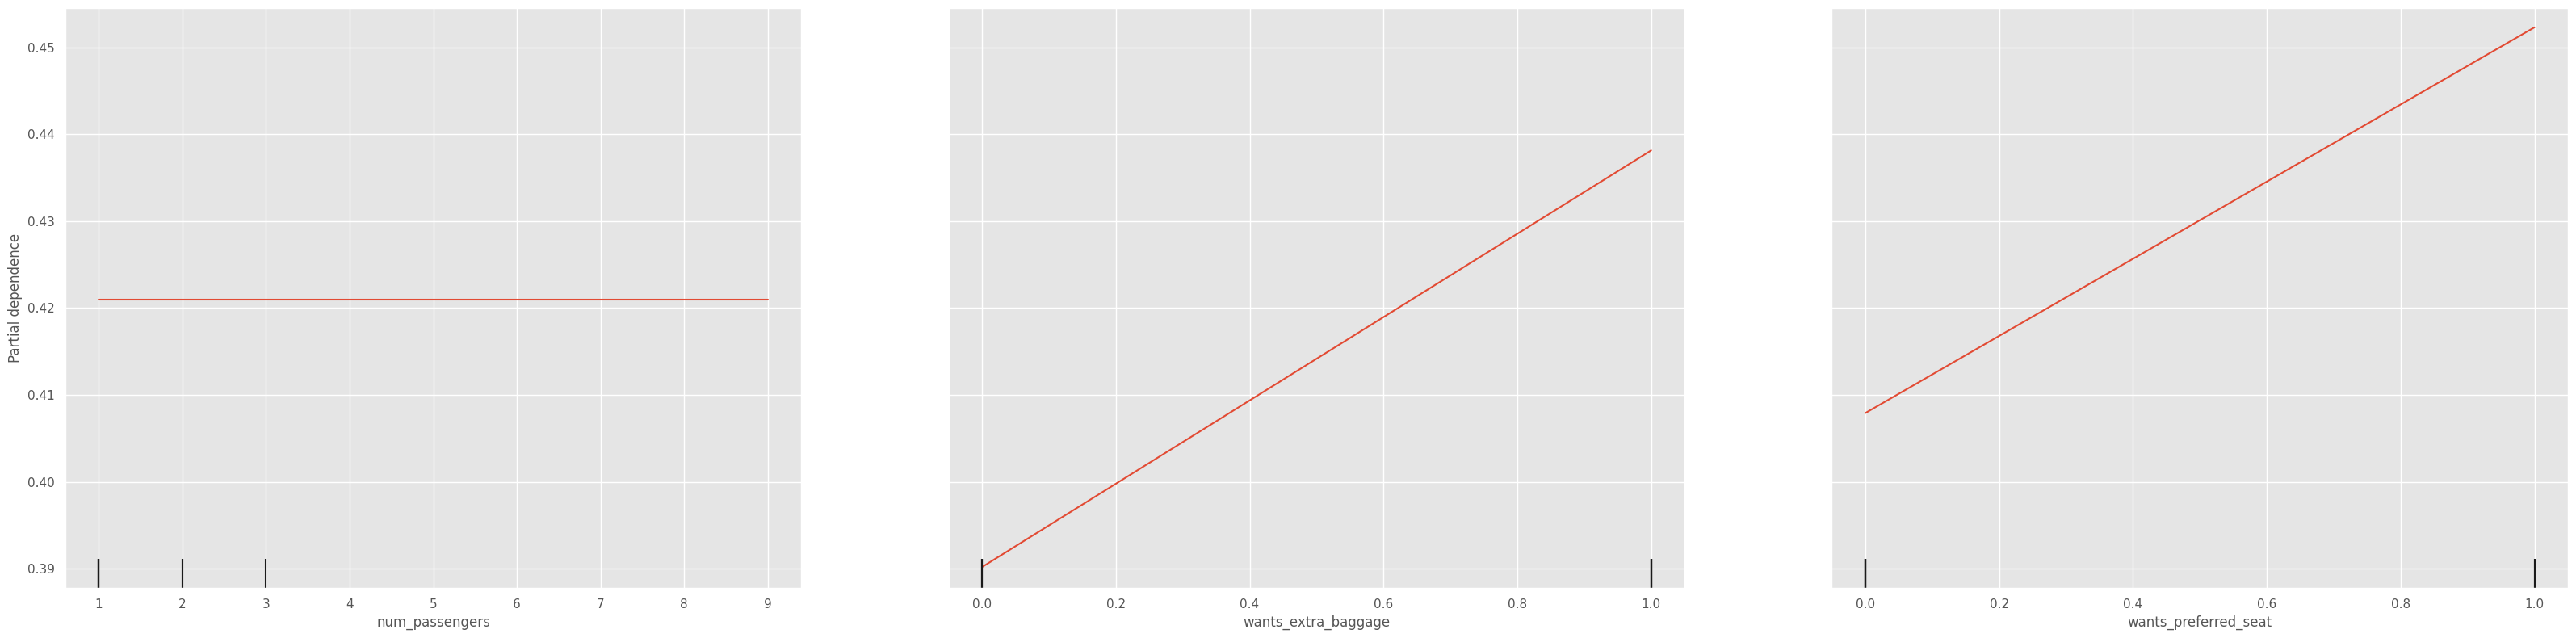

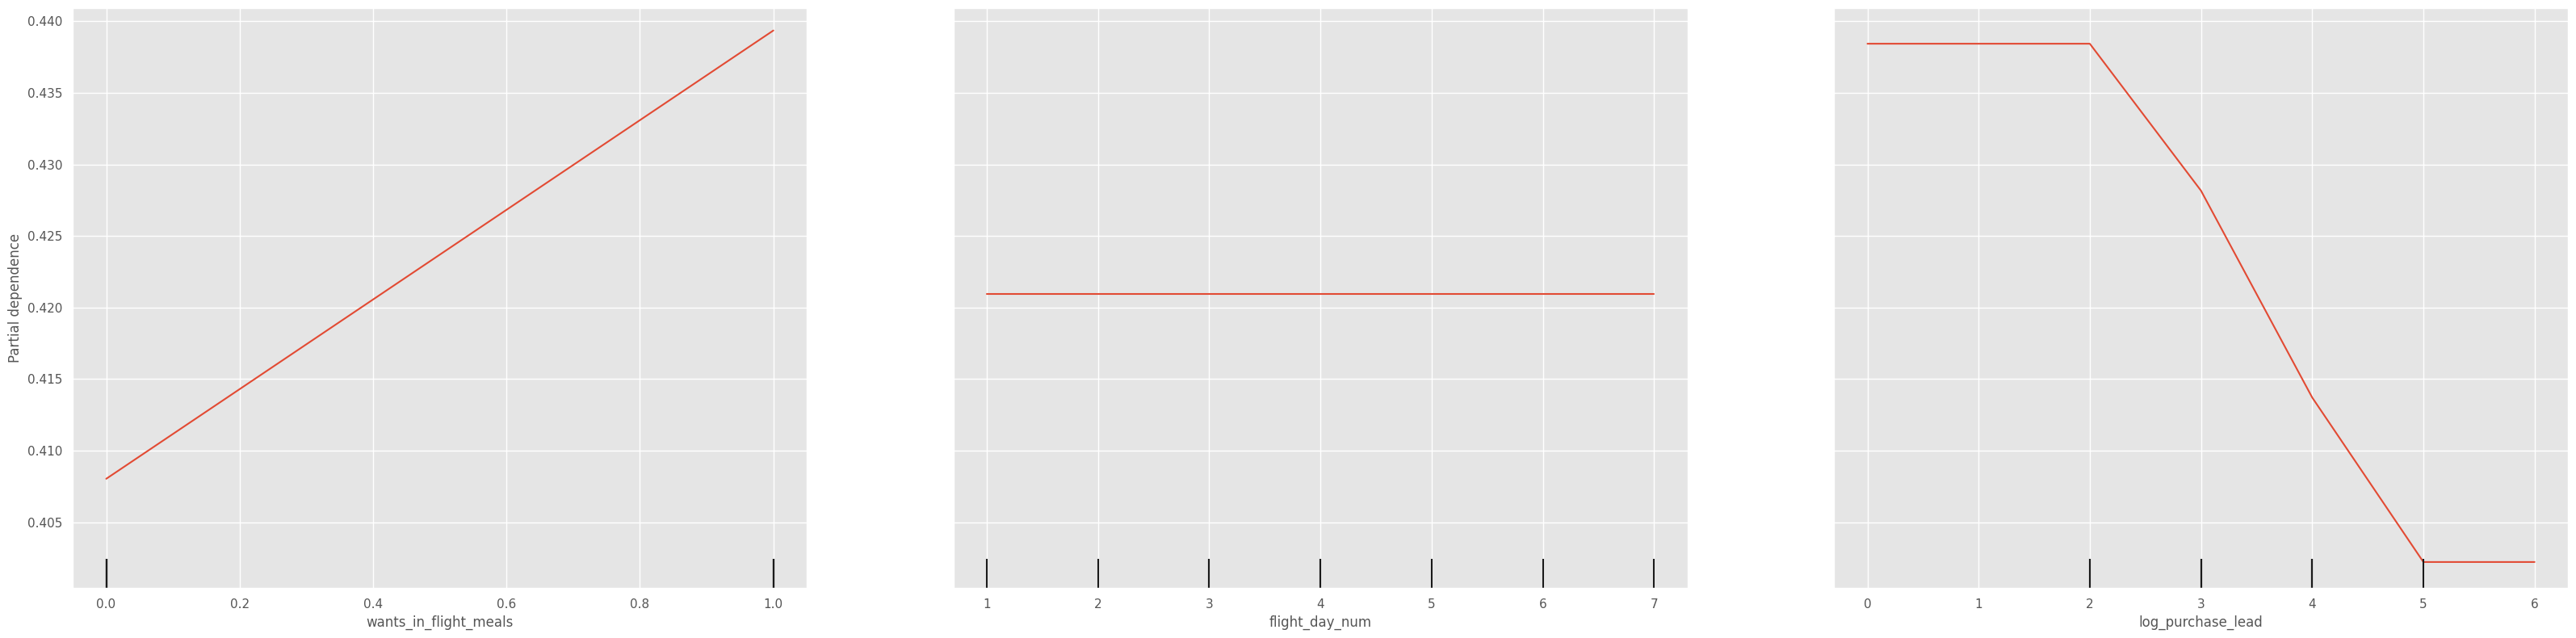

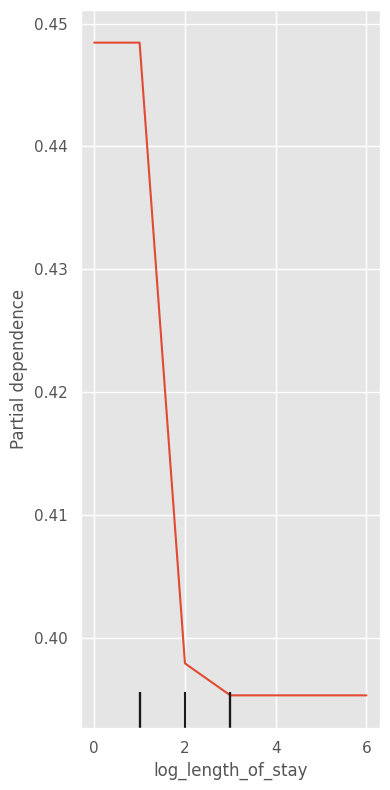

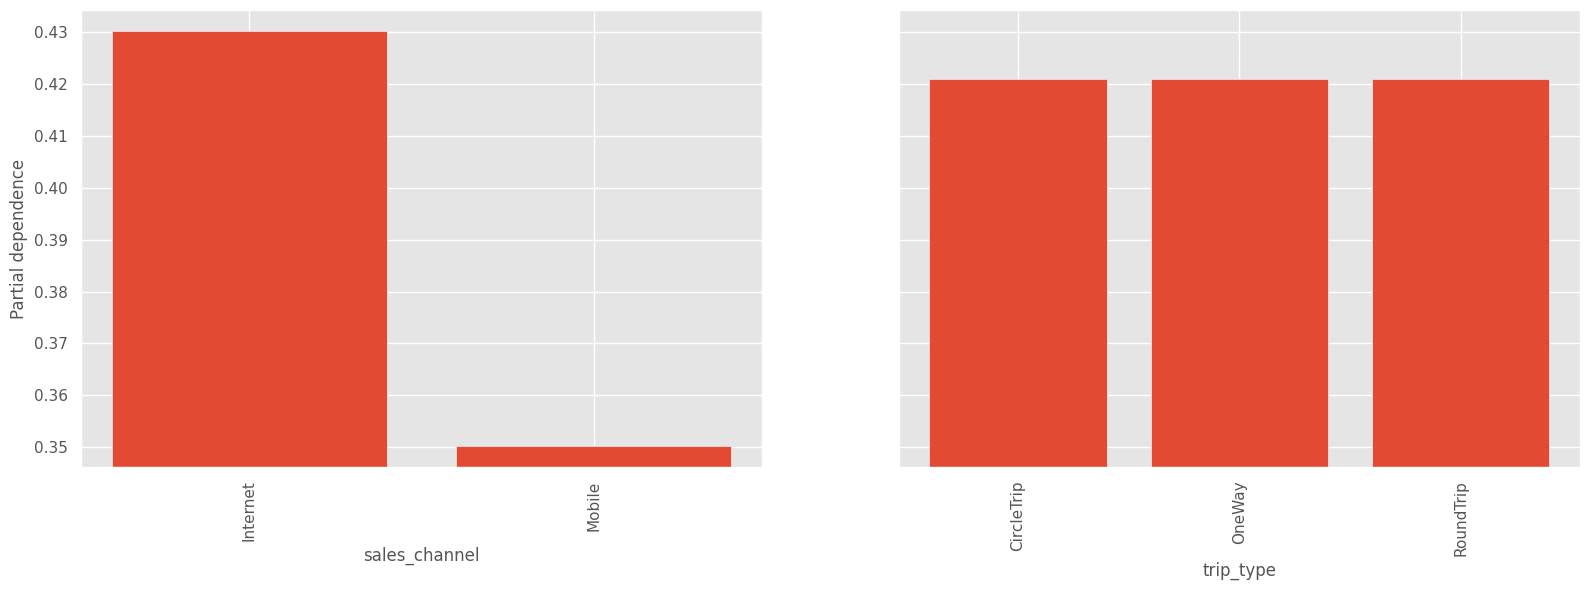

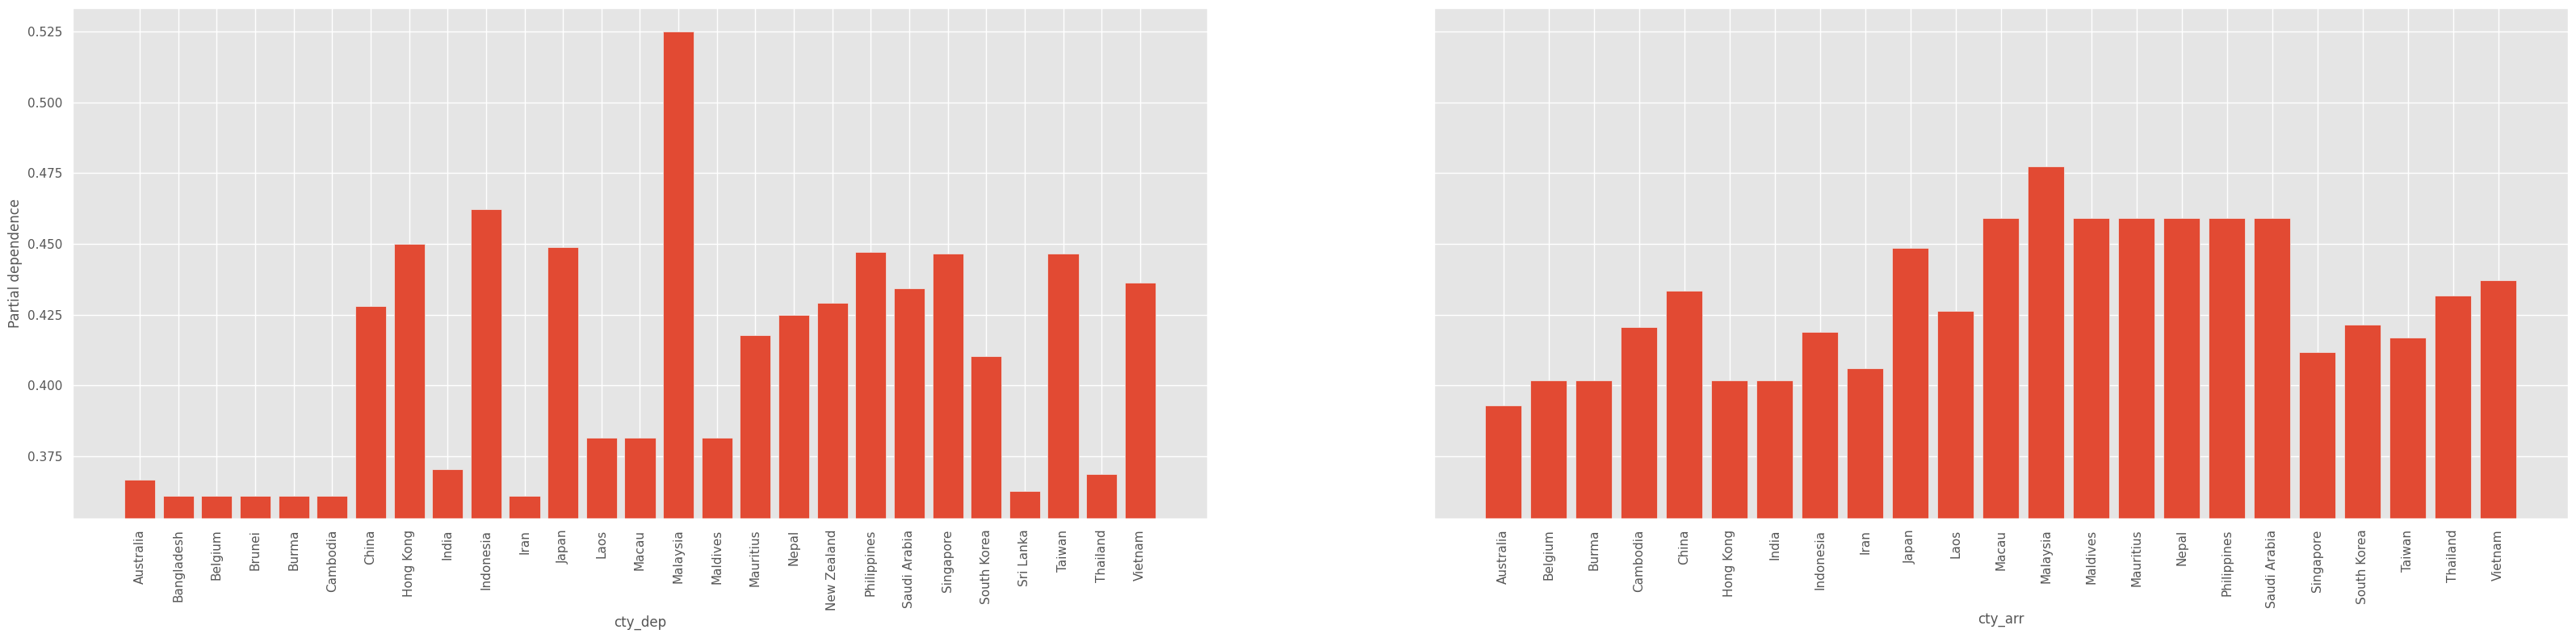

In [172]:
from sklearn.inspection import PartialDependenceDisplay, partial_dependence

cat_features = X_train.select_dtypes('category').columns.tolist()

'''
From this particular graph, we see that lower values of log_length_of_stay has a higher
impact on booking completion (or the changes in prediction).

But larger log(periods of stay) beyond a value of 3 appear to have little impact on predictions

'''
# Create a figure and axis
fig, ax = plt.subplots(figsize=(32, 8))
disp1 = PartialDependenceDisplay.from_estimator(xgb_refit, X_test,
                                                X_train.select_dtypes(np.number).columns.tolist()[:3],
                                                categorical_features=cat_features, ax=ax)
plt.tight_layout()
plt.show();

# Create a figure and axis
fig, ax = plt.subplots(figsize=(32, 8))
disp1 = PartialDependenceDisplay.from_estimator(xgb_refit, X_test,
                                                X_train.select_dtypes(np.number).columns.tolist()[3:6],
                                                categorical_features=cat_features, ax=ax)
plt.tight_layout()
plt.show();

# Create a figure and axis
fig, ax = plt.subplots(figsize=(4, 8))
disp1 = PartialDependenceDisplay.from_estimator(xgb_refit, X_test,
                                                X_train.select_dtypes(np.number).columns.tolist()[6:],
                                                categorical_features=cat_features, ax=ax)
plt.tight_layout()
plt.show();


# Create a figure and axis
fig, ax = plt.subplots(figsize=(16, 6))
disp1 = PartialDependenceDisplay.from_estimator(xgb_refit, X_test,
                                                X_train.drop(['route',
                                                              'port_arr',
                                                              'port_dep',
                                                              'booking_origin'], axis=1).select_dtypes('category').columns.tolist()[:2],
                                                categorical_features=cat_features, ax=ax)
plt.tight_layout()
plt.show();

# Create a figure and axis
fig, ax = plt.subplots(figsize=(32, 8))
disp1 = PartialDependenceDisplay.from_estimator(xgb_refit, X_test,
                                                X_train.drop(['route',
                                                              'port_arr',
                                                              'port_dep',
                                                              'booking_origin'], axis=1).select_dtypes('category').columns.tolist()[2:],
                                                categorical_features=cat_features, ax=ax)
plt.tight_layout()
plt.show();

**Key Takeaways:**


1.   `num_passengers` and `flight_day_num` had constant effect on predictions generated across all values
2.   `log_length_of_stay` and `log_purchase_lead` had a stark difference in predictions between lower and higher values. This suggests that large outliers had little local effects.



<a id = '5.4'></a>
## [5.4 SHAP Model Explanations](#0)
What if you want to break down how the model works for an individual prediction?

SHAP Values (an acronym from SHapley Additive exPlanations) break down a prediction to show the impact of each feature. Where could you use this?

 >-   A model says a bank shouldn't loan someone money, and the bank is legally required to explain the basis for each loan rejection
 >-   A healthcare provider wants to identify what factors are driving each patient's risk of some disease so they can directly address those risk factors with targeted health interventions

 SHAP Values can be used to explain individual predictions, as well as model-level insights.

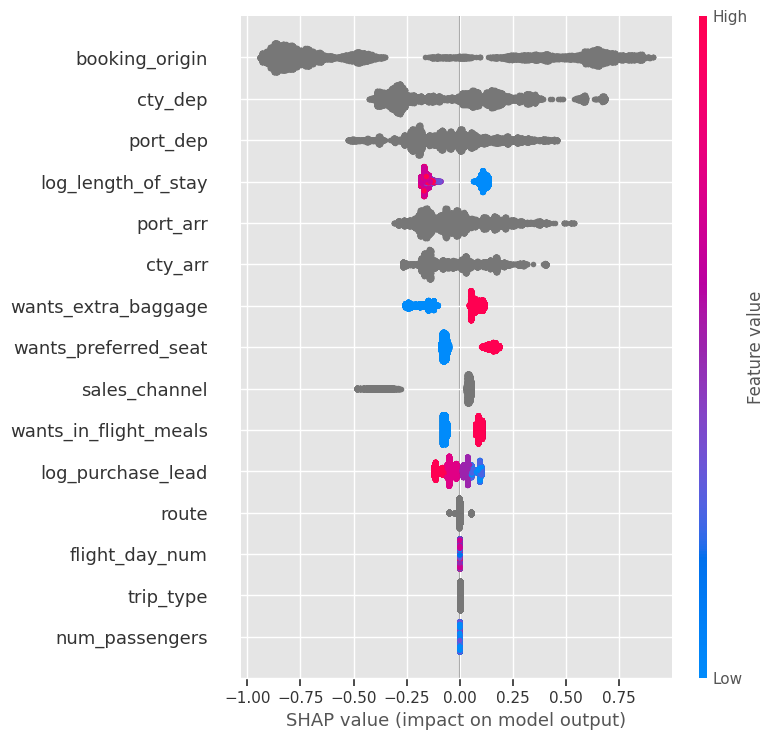

In [173]:
# Local explanations

# SHAP values
explainer = shap.Explainer(xgb_refit)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, title = 'SHAP Summary Plot')


## **How to interpret SHAP plot**



This plot is made of many dots. Each dot has three characteristics:

 >-   Vertical location shows what feature it is depicting
 >-   Color shows whether that feature was high or low for that row of the datase
>-    Horizontal location shows whether the effect of that value caused a higher or lower prediction.
>>- The extent of distribution shows the strength of the feature on the prediction.

**For Eg,
  A higher value of `sales_channel` has a stronger effect (25% contribution) on negative class predictions (due to its larger extent of distribution) while a lower value has a weaker effect on positive class prediction (due to its smaller extent of distribution).**

In [ ]:
shap.plots.force(explainer.expected_value, 
                 shap_values=shap_values[0],
                 features=X_test.iloc[0], 
                 feature_names=X_test.columns.tolist())